#Overview and instructions

The goal of this project was to create covinient way of genrating interpolations for given data. We tried to make an easy to use class with sklearn-like api. The documantations should be enough to understand the workflow.

For leymans:
Interpolation means fitting a well decribed function to the data so that the generated function will pass through the given points.

**REMEMBER THAT INTERPOLATION IS NOT THE SAME AS REGREESSION!!!**

fitting the curve to the given function is only a side effect of the process

If u are unfamiliar with interpolation and dont want to get into details, just compile: Imports, Functions and Class interpolation. Now u can go to Animations and take a look how does it work (note that it takes a while to compile).





# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from matplotlib import animation, rc
from IPython.display import HTML
import cmath 
warnings.filterwarnings('ignore')

# Functions

## Side functions

### Gauss-Seidel

In [ ]:
def gauss_seidel(A, b, x0 = None, iterations = 100):
  '''
  Solves system of equations using Gauss-Seidel method

  A - array of system coeficients [numpy array]

  b - vector of system constants [numpy array]

  x0 - starting points [numpy array]

  iterations - number of iterations for method [float]

  Note that this method has some assumptions and hence it will not work for every system of equations. 
  '''
  if x0==None:
    x0=np.zeros(A.shape[0])
  n = A.shape[0]
  x = x0
  x_prev = x0

  for i in range(iterations):
    for i in range(n):
      s = 0
      for j in range(i):
        s += A[i,j] * x_prev[j]
      for j in range(i+1, n):
        s += A[i,j] * x_prev[j]
      x[i] = (b[i]-s) / A[i,i]
    x_prev = x
  return x
  


### Binary seach for adjescent nodes

In [ ]:
def adjescent_nodes(X, x):  
  '''
  Finds two elements of X closest to x and returns their indexes
  X - array of sorted arguments [numpy array]
  x - value for which adjescent nodes will be found [float]
  '''

  low = 0
  high = len(X)

  mid = (low+high)//2
  while low<=high:
    if X[mid]<x:
      if X[mid+1]>=x:
        i0, i1 = mid, mid+1
        break
      low=mid
      mid=(low+high)//2
      
    elif X[mid]>=x:
      if X[mid-1]<=x:
        i0, i1 = mid-1, mid
        break
      high=mid
      mid=(low+high)//2
  return i0, i1

### Chebyshev Nodes

In [ ]:
def chebyshev_nodes(a, b, n,):
  """
  Generates points on given interval distributed according to Chebyshev polynomial roots.
  
  a - start of the interval [float]
  
  b - end of the interval [float]
  
  n - number of nodes to generate.

  Note that only n-2 points will be generated as Chebyshev polynomial roots,
  the remaining 2 will be added as end points of the interval
  """
  X_nodes=[(np.cos((2*j-1)/(2*(n-2))*np.pi)+1)/2*(b-a)+a for j in range(n-2,0,-1)]
  X_nodes.append(b)
  X_nodes.insert(0, a)
  return X_nodes

##Linear Spline

In [ ]:
def linear(X, Y, get_formula=True):
  '''
  Creates linear spline for given data. Returns interpolation function and formula

  X - x coordinates of nodes [numpy array]

  Y - y cooridinates of nodes corresponding to X [numpy array]

  get_formula - determines whether to create string containing the formula of interpolation or not [bool] 
  '''
  def interp(x):
    i0, i1 = adjescent_nodes(X, x)
    
    return Y[i0]+(x-X[i0])*(Y[i1]-Y[i0])/(X[i1]-X[i0])

  formula = ''
  if (get_formula):
    for i in range(len(X)-1):
      formula+='for x in [{:.3f}, {:.3f}]       {:.3f}x+{:.3f}'.format( X[i], X[i+1], (Y[i+1]-Y[i])/(X[i+1]-X[i]), Y[i] - X[i]* (Y[i+1]-Y[i])/(X[i+1]-X[i]))
      formula+="\n"
    formula= formula.replace('+-', '-')


  return interp, formula
  


##Quadratic Spline

In [ ]:
def quadratic(X, Y, get_formula=True):
  '''
  Creates quadratic spline for given data. Returns interpolation function and formula.

  X - x coordinates of nodes [numpy array]

  Y - y cooridinates of nodes corresponding to X [numpy array] 

  get_formula - determines whether to create string containing the formula of interpolation or not [bool]
  '''
  n=len(X)-1
  Z=[]
  Z.append(0)
  for i in range(n):
      Z.append(-Z[i]+2*((Y[i+1]-Y[i])/(X[i+1]-X[i])))

  def Polynomial(x):
    i0, i1 = adjescent_nodes(X, x)
    return ((Z[i0+1]-Z[i0])/(2*(X[i0+1]-X[i0]))) * (x-X[i0])**2 + Z[i0]*(x-X[i0]) + Y[i0]

  if(get_formula==True):
      formula = ""
      for i in range(n):
          a = (Z[i+1]-Z[i])/(2*(X[i+1]-X[i]))
          formula = formula + "For x in [{:.3f},{:.3f}]    {:.3f}x^2 + {:.3f}x + {:.3f} \n".format(
              X[i], X[i+1], a, -2*a*X[i]+Z[i], a*X[i]*X[i]-Z[i]*X[i]+Y[i]).replace("+ -","- ")
  else:
      formula = None
        
  return Polynomial, formula

##Cubic spline

In [ ]:
def cubic(X, Y,  get_formula=True):
  '''
  Creates cubic spline for given data. Returns interpolation function and formula.

  X - x coordinates of nodes [numpy array]

  Y - y cooridinates of nodes corresponding to X [numpy array]
  
  get_formula - determines whether to create string containing the formula of interpolation or not [bool] 
  '''
  size = len(X)
  delta_x = X[1:]-X[:-1]
  delta_y = Y[1:]-Y[:-1]
 
  A = np.zeros(shape = (size,size))
  b = np.zeros(shape=(size,1))
  A[0,0] = 1
  A[-1,-1] = 1
 
  for i in range(1,size-1):
    A[i, i-1] = delta_x[i-1]
    A[i, i+1] = delta_x[i]
    A[i,i] = 2*(delta_x[i-1]+delta_x[i])
    b[i,0] = 3*(delta_y[i]/delta_x[i] - delta_y[i-1]/delta_x[i-1])
 
  c=gauss_seidel(A, b)
 
 
  d = np.zeros(size-1)
  b = np.zeros(size-1)
  for i in range(size-1):
    b[i] = (delta_y[i]/delta_x[i]) - (delta_x[i]/3)*(2*c[i] + c[i+1])
    d[i] = (c[i+1] - c[i]) / (3*delta_x[i])
  
   
  def interp(x):
    if (x < X[0]) or (x > X[-1]):
      print("{} jest spoza zakresu".format(x))
      return None
    i0, i1 = adjescent_nodes(X, x)
 
 
    return Y[i0]+b[i0]*(x-X[i0])+c[i0]*((x-X[i0])**2)+d[i0]*(x-X[i0])**3
 
  formula = ''
  if (get_formula):
    for i in range(size-1):
      formula+='for x in [{:.3f}, {:.3f}]       {:.3f}x^3+{:.3f}x^2+{:.3f}x+{:.3f}'.format( X[i], X[i+1], d[i], c[i]-3*d[i]*X[i], b[i]-2*c[i]*X[i]+3*d[i]*X[i]**2, Y[i]-b[i]*X[i]-d[i]*X[i]**3+c[i]*X[i]**2)
      formula+="\n"
    formula = formula.replace('+-', '-')
 
 
  return interp, formula

##Lagrange

In [ ]:
def lagrange(X, Y, get_formula=True):
  '''
  Creates Lagrange's polynomial interpolation for given data. Returns interpolation function and formula.

  X - x coordinates of nodes [numpy array]

  Y - y cooridinates of nodes corresponding to X [numpy array]
  
  get_formula - determines whether to create string containing the formula of interpolation or not [bool] 
  '''
  n=len(X)
  D = []

  for k in range(n):
      denom = 1
      for i in range(n):
          if i!=k:
              denom = denom * (X[k]-X[i])
      D.append(denom)

  def Base(x,k):
      B = 1
      for i in range(n):
          if i!=k:
              B = B*(x-X[i])
      return B/D[k]          

  def Polynomial(x):
      pol = 0
      for i in range(n):
          pol = pol + Y[i] * Base(x,i)
      return pol

  if(get_formula==True):
      formula = ""

      for k in range(n):
          b = ''
          for i in range(n):
              if i!=k:
                  b = (b + '(x-{:.3f})'.format(X[i])).replace('--','+')
          b = '{:.3f}/{:.3f}'.format(Y[k],D[k]) + '*' + b 
          formula = formula + b + "+ \n"
      formula = formula[:-3]
      
  else:
      formula = None

  return Polynomial, formula

## Trigonometric

In [ ]:
def trigonometric(X, Y, get_formula=True):
  '''
  Creates trigonometric polynomial interpolation for given data. Returns interpolation function and formula.

  X - x coordinates of nodes [numpy array]

  Y - y cooridinates of nodes corresponding to X [numpy array]
  
  get_formula - determines whether to create string containing the formula of interpolation or not [bool] 
  '''
  n = len(X)
  A= [] 
  for i in range(n):
      A.append(1)
      for j in range(n):
          if j != 0:
              A.append(cmath.exp(1j * X[i] * j))
  A = np.array(A)
  A = A.reshape(n,n)
  Y = np.array(Y) 
  solution = np.linalg.solve(A, Y)

  def polynomial(x):
      poly_of_x = 0
      for k in range(n):
          poly_of_x += solution[k] * cmath.exp(1j * k * x)
      return round(poly_of_x.real, 6)

  if(get_formula):
      formula = '{:.3f} + '.format(round(solution[0].real, 4))

      for k in range(n):
          if k != 0:
              b = '{:.3f}*e^({:.0f}ix) + '.format(round(solution[k].real, 4), k)
              formula = formula + b
      formula = formula.replace(' + -',' - ')
      formula = formula[:-3]
  else:
      formula = None
  
  return polynomial, formula


# Class interpolation

In [ ]:
class interpolation:
  """
  Base class for interpolation.
  
  int_type - type of interpolation. [string] 
  Avaiable:
  'linear' - linear spline
  'quadratic' - quadratic spline
  'cubic' - natural cubic spline
  'lagrange' - Lagrange interpolation
  'trigonometric' - trigonometric interpolation
  """
  func = None
  X = None
  Y = []
  formula = ''


  def __init__(self, int_type='linear'):
    """ """
    self.int_type = int_type 

  
  def fit(self, X, Y=None, func=None, get_formula = True, sorted=False):
    """Fits interpolation function to the data.
    
    X - x coordinates of nodes [numpy array]

    Y - y coordinates of nodes [numpy array]

    func - if given calculates Y as func(X) [callable]

    get_formula - definies whether the formula string will be computed or not [bool]
    """
    
    if (func!=None):
      Y = func(X)
      self.func = func
    if not sorted:
      Y = Y[np.argsort(X)]
      X.sort()
    if (Y==[] and func==None):
      print("Y or func is expected")
      return

    self.X = X
    self.Y = Y

    if (self.int_type == 'linear'):
      self.interpolate, self.formula = linear(X, Y, get_formula=get_formula)

    elif (self.int_type == 'quadratic'):
      self.interpolate, self.formula = quadratic(X, Y, get_formula=get_formula)
      
    elif (self.int_type == 'cubic'):
      self.interpolate, self.formula = cubic(X, Y, get_formula=get_formula)
      
    elif (self.int_type == 'lagrange'):
      self.interpolate, self.formula = lagrange(X, Y, get_formula=get_formula)
      
    elif (self.int_type == 'trigonometric'):
      self.interpolate, self.formula = trigonometric(X, Y, get_formula=get_formula)
      

  def bestfit(self, a, b, func, nodes_type='equidistant' ,max_iters=10000, start=3, step=10, tolerance=1e-10, verbose=0, norm='L2', trials=5, last_errors_plot=50):
    """Tries to fit interpolation to the function so that the error is below given threshold.
    
    a - start point of the interval [float]
    
    b - end point of the interval [float]
    
    func - funtion to fit interpolation for [callable]

    nodes_type - determines the distribution of nodes ['equidistant' or 'chebyshev']

    max_iters - maximum number of iterations [int] 

    start - number od nodes to start from [int]
    
    step - determines how many nodes will be added in every iteration [int]
    
    tolerance - if error falls below this value function will stop [float]
    
    verbose - if set to n, current error will be printed every n iterations [int]

    norm  - determines the way that error will be computed ['L2' or 'L1']

    trials - number of of probes for error calculation [int]
    
    last_errors_plot - number of last errors to display on error plot [int] """

    self.func = func
    if (func == None):
      print('no func was given')
      return None

    n = start
    errors_history= []

    if (nodes_type=='equidistant'):
      X_nodes=np.linspace(a, b, n)
    elif (nodes_type=='chebyshev'):
      X_nodes = chebyshev_nodes(a, b, n)
    else:
      print('nodes_type not supported', nodes_type)
      return

    self.fit(X=X_nodes, func = self.func, get_formula=False, sorted=True)
    error = np.array([self.mean_error( [self.X[i]+np.random.random()*(self.X[i+1]-self.X[i]) for i in range(n-2)], norm=norm ) for i in range(5)]).mean()
    errors_history.append(error)
    min_error = (error, n) 
    while (n<= max_iters*step and error>=tolerance):
      n+=step

      if (nodes_type=='equidistant'):
        X_nodes=np.linspace(a,b,n)
      if (nodes_type=='chebyshev'):
        X_nodes = chebyshev_nodes(a, b, n)

      self.fit(X=X_nodes, func = self.func, get_formula=False, sorted=True)
      error = np.array([self.mean_error( [self.X[i]+np.random.random()*(self.X[i+1]-self.X[i]) for i in range(n-2)], norm=norm ) for i in range(trials)]).mean()
      errors_history.append(error)
      if (error < min_error[0]):
        min_error = (error, n)
      if ( verbose!=0 and ((n-start)/step)%verbose==0 ):
        print("{:.0f} iterations have passed, best error until now error{}".format((n-start)/step, min_error[0]))
    
    plt.plot(errors_history[-last_errors_plot:], label='error history')
    plt.xlabel('last iterations')
    plt.ylabel('error')
    plt.legend()

    if (nodes_type=='equidistant'):
        X_nodes=np.linspace(a,b,min_error[1])
    if (nodes_type=='chebyshev'):
        X_nodes = chebyshev_nodes(a, b, min_error[1])

    self.fit(X=X_nodes, func = self.func, get_formula=False, sorted=True)
    print('best fit for {} nodes, with error of {}'.format(len(X_nodes), min_error[0]))


  

  def mean_error(self, X, norm='L2'):
    """Compute error between function and interpolation
    
    X - set for which the error will be computed  [numpy array]

    norm  - determines the way that error will be computed ['L2' or 'L1']
    """
    if (self.func == None):
      print('no func was given')
      return None
    if (norm == 'L2'):
      return np.sqrt(( (list(map(self.interpolate, X))-self.func(X))**2 ).sum())/len(X)
    if (norm == 'L1'):
      return np.abs( list(map(self.interpolate, X))-self.func(X) ).sum()/len(X)



  def graph(self, axline='both'):
    """Plots the graph of interpolation, nodes and interpolated function if such was given.

    axline - determines which axlines will be drawn ['both', 'horizntal' or ' vertical]
     """
    ls = np.linspace(self.X[0], self.X[-1], 2000)
    plt.plot(self.X, self.Y, 'o',alpha=0.6, label='interpolation points')
    if (self.func!=None):
      name = str(self.func).split(' ')[1].replace('>', '')
      plt.plot(ls, self.func(ls), '--', alpha=0.6, label='interpolated function: '+name)
    plt.plot(ls, list(map(self.interpolate,ls)), label='interpolation')
    plt.grid(True)
    plt.legend()
    if (axline=='horizontal' or axline=='both'):
      plt.axhline(y=0, color='k')
    if (axline=='vertical' or axline=='both'):
      plt.axvline(x=0, color='k')
    
  def Animation(self, a, b, func, n=20, norm='L2', nodes_type='equidistant'):
    '''
    Creates animation showing how the interpolation behaves for different number of nodes.

    a - start of the interval [float]

    b - end point of the interval [float] 

    func - func to be interpolated [callable]

    n - number of nodes for last frame [int]

    norm - norm for error measurement ['L2' or 'L1']

    nodes_type - type of nodes distribution ['equidistant' or 'chebyshev']
    '''
    X_values = np.linspace(a, b, 1000)
    Y_values = func(X_values)
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.close()
    min_=min(Y_values)
    max_=max(Y_values)
    
    ax.set_xlim(( a, b))
    ax.set_ylim(min_-(max_-min_)/3, max_+(max_-min_)/3)

    line1, = ax.plot([], [], lw=2, alpha=0.6, linestyle='dashed')
    line2, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], lw=2, marker='o', linestyle='None')   

    def init():
        line1.set_data(X_values, Y_values)      
        return (line1,)

    def animate(i):
      
      if (nodes_type=='equidistant'):
        X=np.linspace(a,b,3+i)
      if (nodes_type=='chebyshev'):
        X=chebyshev_nodes(a, b, 3+i)
      
      X_graph=np.linspace(a,b,1000)
      inter.fit(X=X, func=func, get_formula=False, sorted=True)
      Y=list(map(inter.interpolate, X))
      Y_graph= list(map(inter.interpolate, X_graph))
      line2.set_data(X_graph, Y_graph) 
      line3.set_data(X,Y)
      error = np.array([self.mean_error( [X[k]+np.random.random()*(X[k+1]-X[k]) for k in range(i+1)], norm='L2' ) for k in range(5)]).mean()
      ax.set_title("Error: {}\n Nodes : {}".format(error,3+i))
      return (line2,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=n-2, interval=100, blit=True)

    rc('animation', html='jshtml')
    return anim
  
  def print_formula(self):
    '''
    Prints the formula of interpolation finction if avaiable.
    '''
    if (self.formula == '' or self.formula == None):
      print('formula not avaiable')
    else:
      print(self.formula)

# Testing

### Testing for given X and Y 

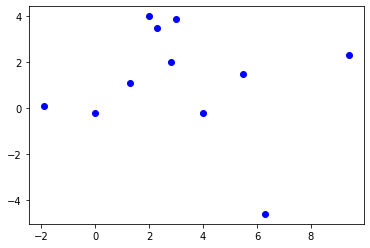

In [ ]:
X_test = np.array([-1.9, 0, 1.3, 2, 2.3, 2.8, 3, 4, 5.5, 6.3, 9.4 ])
Y_test = np.array([0.1, -0.2, 1.1, 4, 3.5, 2, 3.9, -0.2, 1.5, -4.6, 2.3])
plt.plot(X_test, Y_test, 'bo')
plt.show()

####Linear interpolation

In [ ]:
inter = interpolation(int_type='linear')
inter.fit(X=X_test, Y=Y_test)

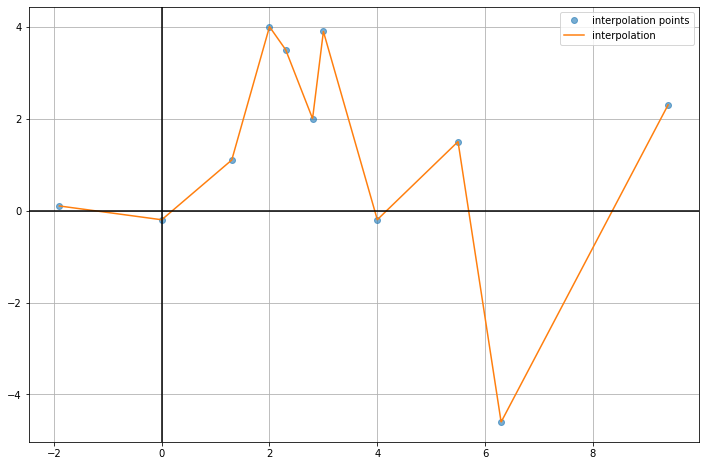

In [ ]:
plt.figure(figsize=(12,8))
inter.graph()

In [ ]:
inter.print_formula()

for x in [-1.900, 0.000]       -0.158x-0.200
for x in [0.000, 1.300]       1.000x-0.200
for x in [1.300, 2.000]       4.143x-4.286
for x in [2.000, 2.300]       -1.667x+7.333
for x in [2.300, 2.800]       -3.000x+10.400
for x in [2.800, 3.000]       9.500x-24.600
for x in [3.000, 4.000]       -4.100x+16.200
for x in [4.000, 5.500]       1.133x-4.733
for x in [5.500, 6.300]       -7.625x+43.438
for x in [6.300, 9.400]       2.226x-18.623



#### Quadratic interpolation


In [ ]:
inter = interpolation(int_type='quadratic')
inter.fit(X=X_test, Y=Y_test)

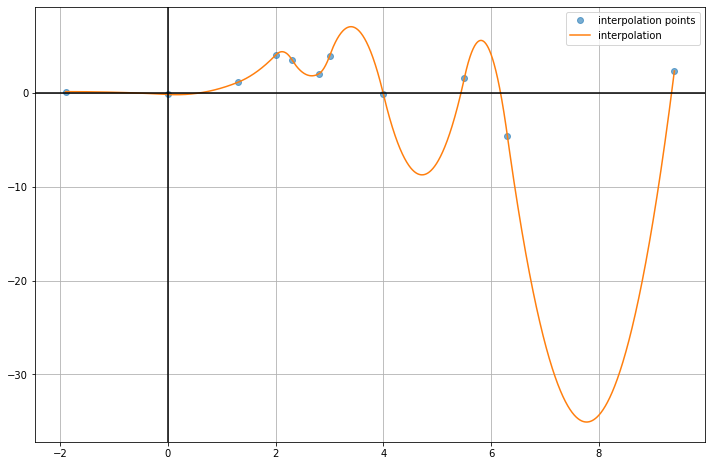

In [ ]:
plt.figure(figsize=(12,8))
inter.graph()

In [ ]:
inter.print_formula()

For x in [-1.900,0.000]    -0.083x^2 - 0.316x - 0.200 
For x in [0.000,1.300]    1.012x^2 - 0.316x - 0.200 
For x in [1.300,2.000]    2.610x^2 - 4.470x + 2.501 
For x in [2.000,2.300]    -25.455x^2 + 107.791x - 109.761 
For x in [2.300,2.800]    12.607x^2 - 67.293x + 91.586 
For x in [2.800,3.000]    30.984x^2 - 170.206x + 235.663 
For x in [3.000,4.000]    -19.797x^2 + 134.477x - 221.361 
For x in [4.000,5.500]    16.687x^2 - 157.390x + 362.374 
For x in [5.500,6.300]    -42.236x^2 + 490.754x - 1420.023 
For x in [6.300,9.400]    14.077x^2 - 218.786x + 815.027 



#### Cubic interpolation

In [ ]:
inter = interpolation(int_type='cubic')
inter.fit(X=X_test, Y=Y_test)

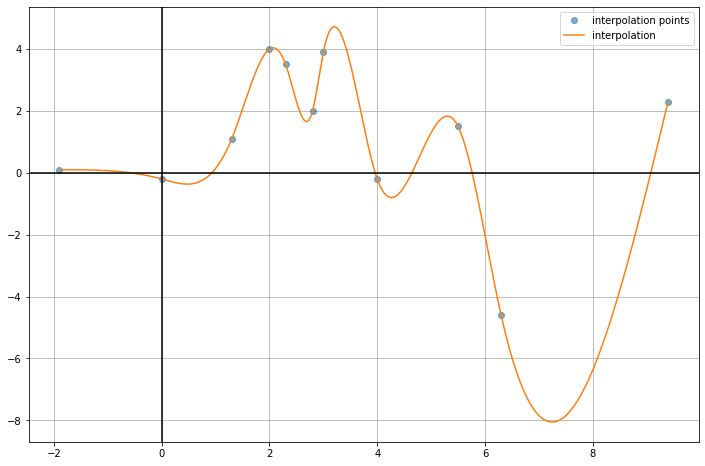

In [ ]:
plt.figure(figsize=(12,8))
inter.graph()

In [ ]:
inter.print_formula()

for x in [-1.900, 0.000]       -0.044x^3-0.248x^2-0.472x-0.200
for x in [0.000, 1.300]       1.062x^3-0.248x^2-0.472x-0.200
for x in [1.300, 2.000]       -5.816x^3+26.578x^2-35.346x+14.912
for x in [2.000, 2.300]       -3.767x^3+14.282x^2-10.754x-1.483
for x in [2.300, 2.800]       30.785x^3-224.130x^2+537.592x-421.882
for x in [2.800, 3.000]       -98.266x^3+859.904x^2-2497.703x+2411.061
for x in [3.000, 4.000]       11.861x^3-131.238x^2+475.723x-562.366
for x in [4.000, 5.500]       -4.724x^3+67.775x^2-320.327x+499.035
for x in [5.500, 6.300]       6.250x^3-113.292x^2+675.544x-1326.728
for x in [6.300, 9.400]       -0.520x^3+14.651x^2-130.500x+365.962



#### Lagrange interpoplation

In [ ]:
inter = interpolation(int_type='lagrange')
inter.fit(X=X_test, Y=Y_test)

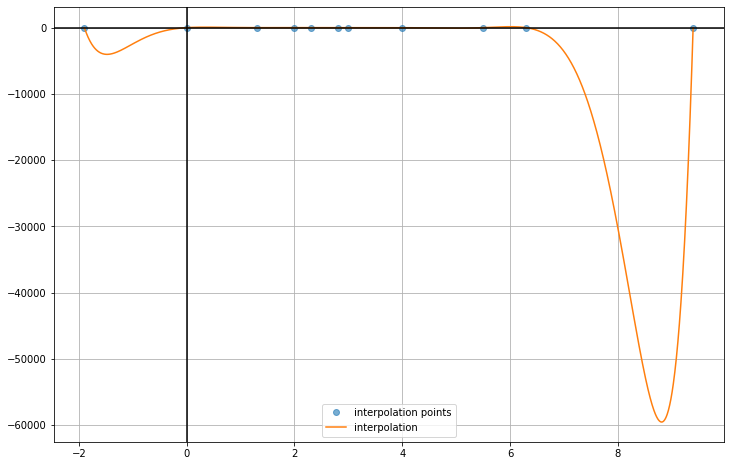

In [ ]:
plt.figure(figsize=(12,8))
inter.graph()

In [ ]:
inter.print_formula()

0.100/9278706.593*(x-0.000)(x-1.300)(x-2.000)(x-2.300)(x-2.800)(x-3.000)(x-4.000)(x-5.500)(x-6.300)(x-9.400)+ 
-0.200/-124344.092*(x+1.900)(x-1.300)(x-2.000)(x-2.300)(x-2.800)(x-3.000)(x-4.000)(x-5.500)(x-6.300)(x-9.400)+ 
1.100/3410.355*(x+1.900)(x-0.000)(x-2.000)(x-2.300)(x-2.800)(x-3.000)(x-4.000)(x-5.500)(x-6.300)(x-9.400)+ 
4.000/-291.878*(x+1.900)(x-0.000)(x-1.300)(x-2.300)(x-2.800)(x-3.000)(x-4.000)(x-5.500)(x-6.300)(x-9.400)+ 
3.500/156.705*(x+1.900)(x-0.000)(x-1.300)(x-2.000)(x-2.800)(x-3.000)(x-4.000)(x-5.500)(x-6.300)(x-9.400)+ 
2.000/-118.194*(x+1.900)(x-0.000)(x-1.300)(x-2.000)(x-2.300)(x-3.000)(x-4.000)(x-5.500)(x-6.300)(x-9.400)+ 
3.900/184.726*(x+1.900)(x-0.000)(x-1.300)(x-2.000)(x-2.300)(x-2.800)(x-4.000)(x-5.500)(x-6.300)(x-9.400)+ 
-0.200/-4843.383*(x+1.900)(x-0.000)(x-1.300)(x-2.000)(x-2.300)(x-2.800)(x-3.000)(x-5.500)(x-6.300)(x-9.400)+ 
1.500/60479.940*(x+1.900)(x-0.000)(x-1.300)(x-2.000)(x-2.300)(x-2.800)(x-3.000)(x-4.000)(x-6.300)(x-9.400)+ 
-4.600/-292694.360*(

#### Trigonometric interpolation

In [ ]:
inter = interpolation(int_type='trigonometric')
inter.fit(X=X_test, Y=Y_test)

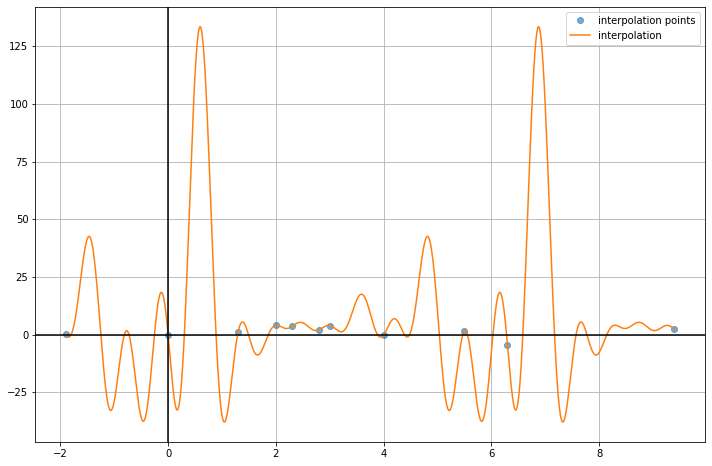

In [ ]:
plt.figure(figsize=(12,8))
inter.graph()

In [ ]:
inter.print_formula()

6.259 + 2.955*e^(1ix) + 3.068*e^(2ix) + 0.008*e^(3ix) - 4.513*e^(4ix) - 10.838*e^(5ix) - 16.049*e^(6ix) - 6.266*e^(7ix) + 5.489*e^(8ix) + 13.111*e^(9ix) + 6.575*e^(10ix)


### Testing using math function

In [ ]:
error_matrix = {}
def x_square(x):
   return np.power(x, 2)

X_test = np.linspace(0, 1, 50)

func_test = {'x^2': x_square,
             'square root': np.sqrt,
             'sinus': np.sin}

In [ ]:
def testing(X_test, int_type, func_test, get_formula=True): 
  inter = interpolation(int_type = int_type)
  for num in func_test: 
    inter.fit(X = X_test, func = func_test[num])
    print('---------------------------------------')
    print('function: ', num)
    plt.figure(figsize=(12,8))
    inter.graph()
    plt.show()
    print('---------------------------------------')
    if (get_formula==True): 
      print('formula: \n')
      inter.print_formula()
      print('---------------------------------------')
    error = inter.mean_error(np.linspace(X_test[0], X_test[-1], len(X_test)+1), norm='L2')
    print('mean L2 error: ', error, '\n')
    temp_formula = ''
    temp_formula += 'error L2 in ' + int_type + ' interpolation for function '  + num
    error_matrix[temp_formula] = error
    error = inter.mean_error(np.linspace(X_test[0], X_test[-1], len(X_test)+1), norm='L1')
    print('mean L1 error: ', error, '\n')
    temp_formula = ''
    temp_formula += 'error L1 in ' + int_type + ' interpolation for function '  + num
    error_matrix[temp_formula] = error
    print('---------------------------------------') 
    print('|||||||||||||||||||||||||||||||||||||||') 
    print('---------------------------------------') 
    print('|||||||||||||||||||||||||||||||||||||||') 

#### Linear interpolation

---------------------------------------
function:  x^2


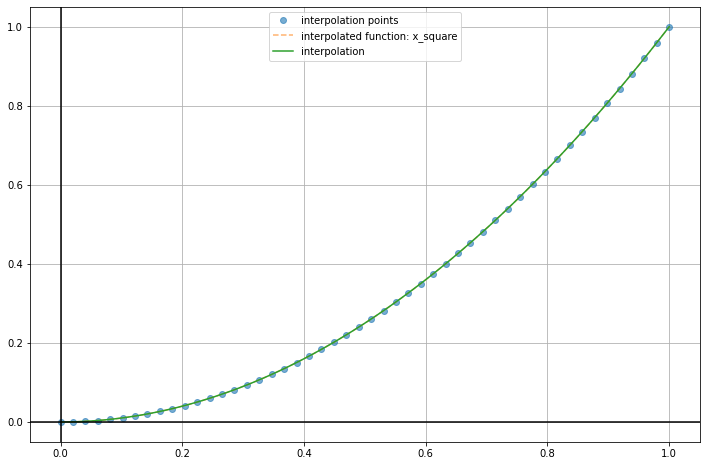

---------------------------------------
formula: 

for x in [0.000, 0.020]       0.020x+0.000
for x in [0.020, 0.041]       0.061x-0.001
for x in [0.041, 0.061]       0.102x-0.002
for x in [0.061, 0.082]       0.143x-0.005
for x in [0.082, 0.102]       0.184x-0.008
for x in [0.102, 0.122]       0.224x-0.012
for x in [0.122, 0.143]       0.265x-0.017
for x in [0.143, 0.163]       0.306x-0.023
for x in [0.163, 0.184]       0.347x-0.030
for x in [0.184, 0.204]       0.388x-0.037
for x in [0.204, 0.224]       0.429x-0.046
for x in [0.224, 0.245]       0.469x-0.055
for x in [0.245, 0.265]       0.510x-0.065
for x in [0.265, 0.286]       0.551x-0.076
for x in [0.286, 0.306]       0.592x-0.087
for x in [0.306, 0.327]       0.633x-0.100
for x in [0.327, 0.347]       0.673x-0.113
for x in [0.347, 0.367]       0.714x-0.127
for x in [0.367, 0.388]       0.755x-0.142
for x in [0.388, 0.408]       0.796x-0.158
for x in [0.408, 0.429]       0.837x-0.175
for x in [0.429, 0.449]       0.878x-0.192
for

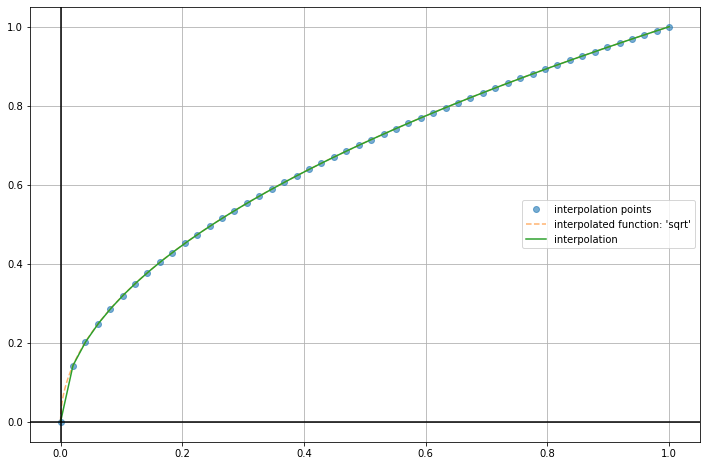

---------------------------------------
formula: 

for x in [0.000, 0.020]       7.000x+0.000
for x in [0.020, 0.041]       2.899x+0.084
for x in [0.041, 0.061]       2.225x+0.111
for x in [0.061, 0.082]       1.876x+0.133
for x in [0.082, 0.102]       1.652x+0.151
for x in [0.102, 0.122]       1.494x+0.167
for x in [0.122, 0.143]       1.374x+0.182
for x in [0.143, 0.163]       1.279x+0.195
for x in [0.163, 0.184]       1.201x+0.208
for x in [0.184, 0.204]       1.136x+0.220
for x in [0.204, 0.224]       1.080x+0.231
for x in [0.224, 0.245]       1.032x+0.242
for x in [0.245, 0.265]       0.990x+0.252
for x in [0.265, 0.286]       0.953x+0.262
for x in [0.286, 0.306]       0.919x+0.272
for x in [0.306, 0.327]       0.889x+0.281
for x in [0.327, 0.347]       0.862x+0.290
for x in [0.347, 0.367]       0.837x+0.299
for x in [0.367, 0.388]       0.814x+0.307
for x in [0.388, 0.408]       0.793x+0.315
for x in [0.408, 0.429]       0.773x+0.323
for x in [0.429, 0.449]       0.755x+0.331
for

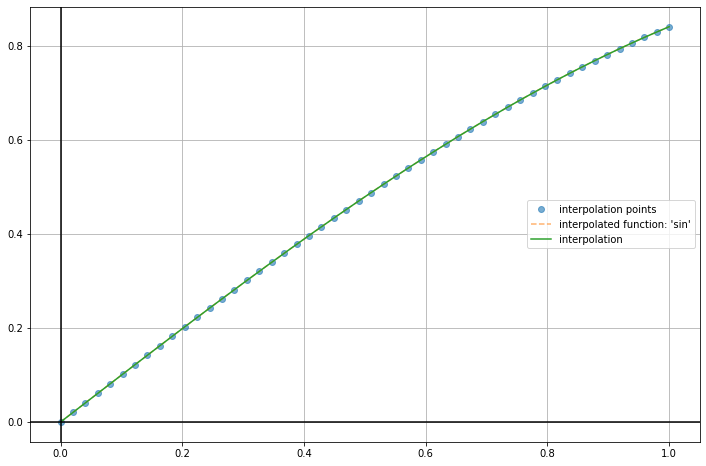

---------------------------------------
formula: 

for x in [0.000, 0.020]       1.000x+0.000
for x in [0.020, 0.041]       1.000x+0.000
for x in [0.041, 0.061]       0.999x+0.000
for x in [0.061, 0.082]       0.997x+0.000
for x in [0.082, 0.102]       0.996x+0.000
for x in [0.102, 0.122]       0.994x+0.000
for x in [0.122, 0.143]       0.991x+0.001
for x in [0.143, 0.163]       0.988x+0.001
for x in [0.163, 0.184]       0.985x+0.002
for x in [0.184, 0.204]       0.981x+0.002
for x in [0.204, 0.224]       0.977x+0.003
for x in [0.224, 0.245]       0.973x+0.004
for x in [0.245, 0.265]       0.968x+0.005
for x in [0.265, 0.286]       0.962x+0.007
for x in [0.286, 0.306]       0.957x+0.009
for x in [0.306, 0.327]       0.950x+0.010
for x in [0.327, 0.347]       0.944x+0.013
for x in [0.347, 0.367]       0.937x+0.015
for x in [0.367, 0.388]       0.930x+0.018
for x in [0.388, 0.408]       0.922x+0.021
for x in [0.408, 0.429]       0.914x+0.024
for x in [0.429, 0.449]       0.905x+0.028
for

In [ ]:
testing(X_test=X_test, int_type='linear', func_test=func_test)

#### Quadratic interpolation

---------------------------------------
function:  x^2


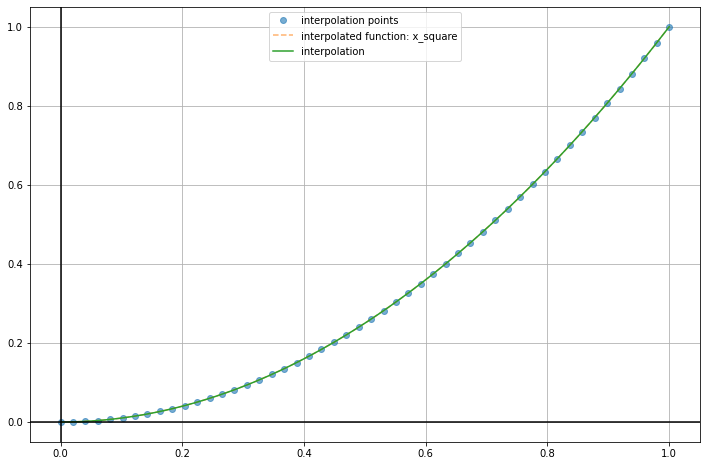

---------------------------------------
formula: 

For x in [0.000,0.020]    1.000x^2 + 0.000x + 0.000 
For x in [0.020,0.041]    1.000x^2 + 0.000x - 0.000 
For x in [0.041,0.061]    1.000x^2 - 0.000x + 0.000 
For x in [0.061,0.082]    1.000x^2 + 0.000x - 0.000 
For x in [0.082,0.102]    1.000x^2 - 0.000x + 0.000 
For x in [0.102,0.122]    1.000x^2 + 0.000x - 0.000 
For x in [0.122,0.143]    1.000x^2 - 0.000x + 0.000 
For x in [0.143,0.163]    1.000x^2 + 0.000x - 0.000 
For x in [0.163,0.184]    1.000x^2 - 0.000x + 0.000 
For x in [0.184,0.204]    1.000x^2 + 0.000x - 0.000 
For x in [0.204,0.224]    1.000x^2 - 0.000x + 0.000 
For x in [0.224,0.245]    1.000x^2 + 0.000x - 0.000 
For x in [0.245,0.265]    1.000x^2 - 0.000x + 0.000 
For x in [0.265,0.286]    1.000x^2 - 0.000x + 0.000 
For x in [0.286,0.306]    1.000x^2 + 0.000x - 0.000 
For x in [0.306,0.327]    1.000x^2 - 0.000x + 0.000 
For x in [0.327,0.347]    1.000x^2 + 0.000x - 0.000 
For x in [0.347,0.367]    1.000x^2 + 0.000x - 0.

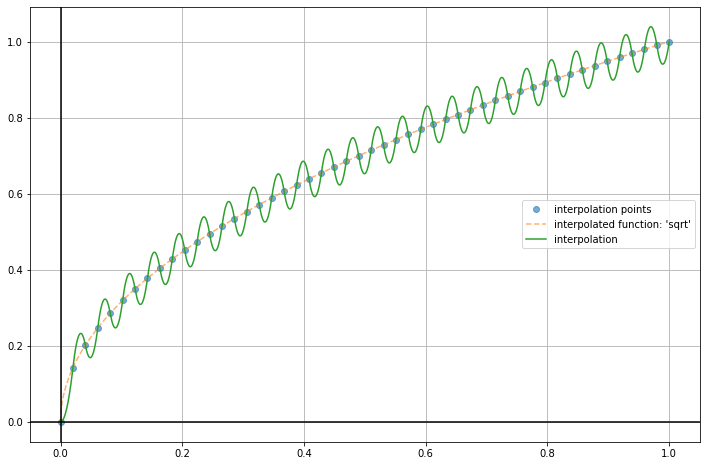

---------------------------------------
formula: 

For x in [0.000,0.020]    343.000x^2 + 0.000x + 0.000 
For x in [0.020,0.041]    -543.925x^2 + 36.201x - 0.369 
For x in [0.041,0.061]    510.868x^2 - 49.904x + 1.388 
For x in [0.061,0.082]    -527.979x^2 + 77.301x - 2.506 
For x in [0.082,0.102]    517.044x^2 - 93.315x + 4.458 
For x in [0.102,0.122]    -524.812x^2 + 119.309x - 6.390 
For x in [0.122,0.143]    518.926x^2 - 136.300x + 9.259 
For x in [0.143,0.163]    -523.586x^2 + 161.560x - 12.017 
For x in [0.163,0.184]    519.777x^2 - 179.130x + 15.795 
For x in [0.184,0.204]    -522.966x^2 + 203.919x - 19.383 
For x in [0.204,0.224]    520.245x^2 - 221.882x + 24.066 
For x in [0.224,0.245]    -522.602x^2 + 246.335x - 28.489 
For x in [0.245,0.265]    520.535x^2 - 264.589x + 34.073 
For x in [0.265,0.286]    -522.367x^2 + 288.788x - 39.334 
For x in [0.286,0.306]    520.728x^2 - 307.267x + 45.817 
For x in [0.306,0.327]    -522.206x^2 + 331.264x - 51.918 
For x in [0.327,0.347]    

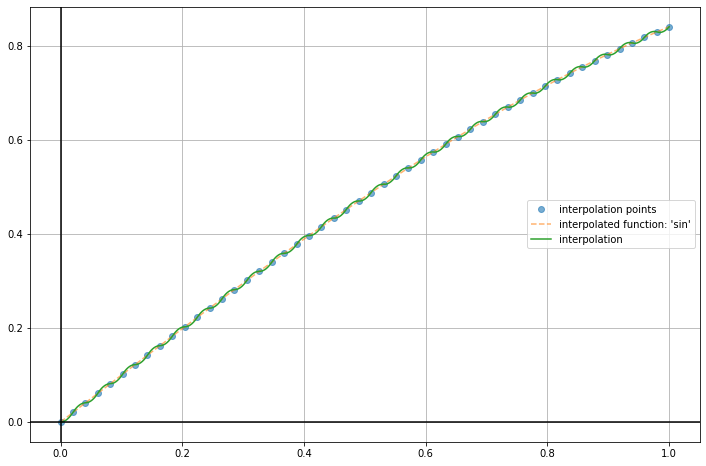

---------------------------------------
formula: 

For x in [0.000,0.020]    48.997x^2 + 0.000x + 0.000 
For x in [0.020,0.041]    -49.017x^2 + 4.001x - 0.041 
For x in [0.041,0.061]    48.976x^2 - 3.999x + 0.122 
For x in [0.061,0.082]    -49.037x^2 + 8.003x - 0.245 
For x in [0.082,0.102]    48.956x^2 - 7.996x + 0.408 
For x in [0.102,0.122]    -49.058x^2 + 12.007x - 0.612 
For x in [0.122,0.143]    48.936x^2 - 11.992x + 0.857 
For x in [0.143,0.163]    -49.078x^2 + 16.012x - 1.143 
For x in [0.163,0.184]    48.915x^2 - 15.986x + 1.469 
For x in [0.184,0.204]    -49.098x^2 + 20.019x - 1.838 
For x in [0.204,0.224]    48.895x^2 - 19.978x + 2.243 
For x in [0.224,0.245]    -49.118x^2 + 24.028x - 2.696 
For x in [0.245,0.265]    48.876x^2 - 23.969x + 3.181 
For x in [0.265,0.286]    -49.138x^2 + 28.038x - 3.718 
For x in [0.286,0.306]    48.856x^2 - 27.958x + 4.282 
For x in [0.306,0.327]    -49.157x^2 + 32.050x - 4.903 
For x in [0.327,0.347]    48.836x^2 - 31.946x + 5.545 
For x in [0

In [ ]:
testing(X_test=X_test, int_type='quadratic', func_test=func_test)

#### Cubic interpolation

---------------------------------------
function:  x^2


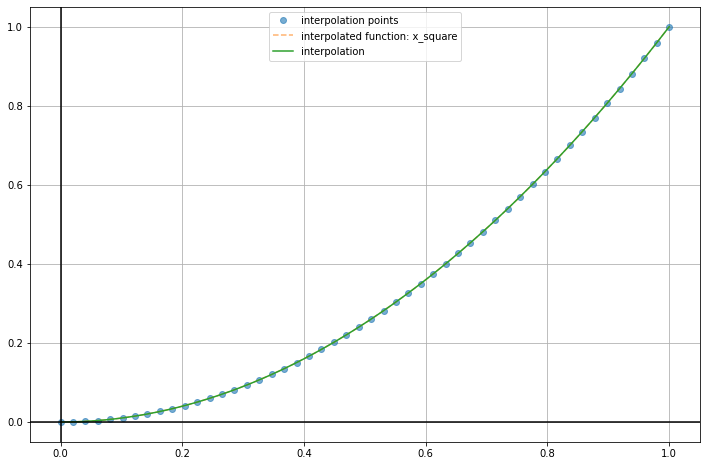

---------------------------------------
formula: 

for x in [0.000, 0.020]       20.710x^3+0.000x^2+0.012x+0.000
for x in [0.020, 0.041]       -5.549x^3+1.608x^2-0.021x+0.000
for x in [0.041, 0.061]       1.487x^3+0.746x^2+0.014x-0.000
for x in [0.061, 0.082]       -0.398x^3+1.092x^2-0.007x+0.000
for x in [0.082, 0.102]       0.107x^3+0.969x^2+0.003x-0.000
for x in [0.102, 0.122]       -0.029x^3+1.010x^2-0.001x+0.000
for x in [0.122, 0.143]       0.008x^3+0.997x^2+0.000x-0.000
for x in [0.143, 0.163]       -0.002x^3+1.001x^2-0.000x+0.000
for x in [0.163, 0.184]       0.001x^3+1.000x^2+0.000x-0.000
for x in [0.184, 0.204]       -0.000x^3+1.000x^2-0.000x+0.000
for x in [0.204, 0.224]       0.000x^3+1.000x^2+0.000x-0.000
for x in [0.224, 0.245]       -0.000x^3+1.000x^2-0.000x+0.000
for x in [0.245, 0.265]       0.000x^3+1.000x^2+0.000x-0.000
for x in [0.265, 0.286]       -0.000x^3+1.000x^2-0.000x+0.000
for x in [0.286, 0.306]       0.000x^3+1.000x^2+0.000x-0.000
for x in [0.306, 0.327]   

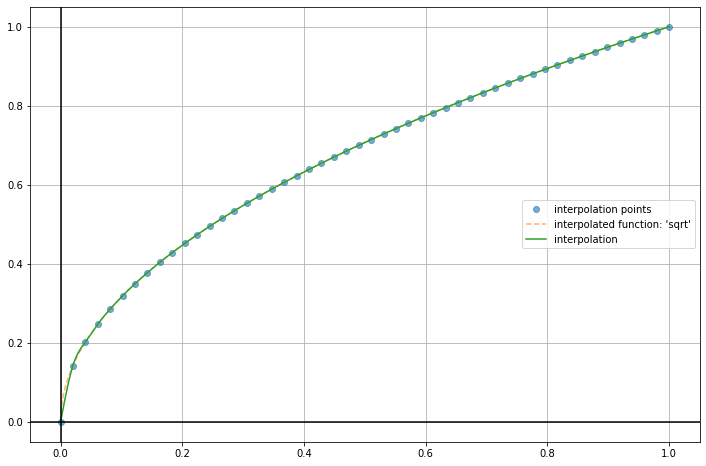

---------------------------------------
formula: 

for x in [0.000, 0.020]       -2535.553x^3+0.000x^2+8.056x+0.000
for x in [0.020, 0.041]       2832.454x^3-328.653x^2+14.763x-0.046
for x in [0.041, 0.061]       -568.745x^3+87.820x^2-2.236x+0.186
for x in [0.061, 0.082]       223.856x^3-57.760x^2+6.677x+0.004
for x in [0.082, 0.102]       -24.037x^3+2.949x^2+1.722x+0.139
for x in [0.102, 0.122]       27.506x^3-12.830x^2+3.332x+0.084
for x in [0.122, 0.143]       6.218x^3-5.010x^2+2.374x+0.123
for x in [0.143, 0.163]       7.699x^3-5.645x^2+2.465x+0.119
for x in [0.163, 0.184]       4.714x^3-4.183x^2+2.226x+0.132
for x in [0.184, 0.204]       3.827x^3-3.694x^2+2.136x+0.137
for x in [0.204, 0.224]       2.913x^3-3.134x^2+2.022x+0.145
for x in [0.224, 0.245]       2.341x^3-2.749x^2+1.936x+0.151
for x in [0.245, 0.265]       1.896x^3-2.422x^2+1.856x+0.158
for x in [0.265, 0.286]       1.566x^3-2.159x^2+1.786x+0.164
for x in [0.286, 0.306]       1.310x^3-1.940x^2+1.723x+0.170
for x in [0.3

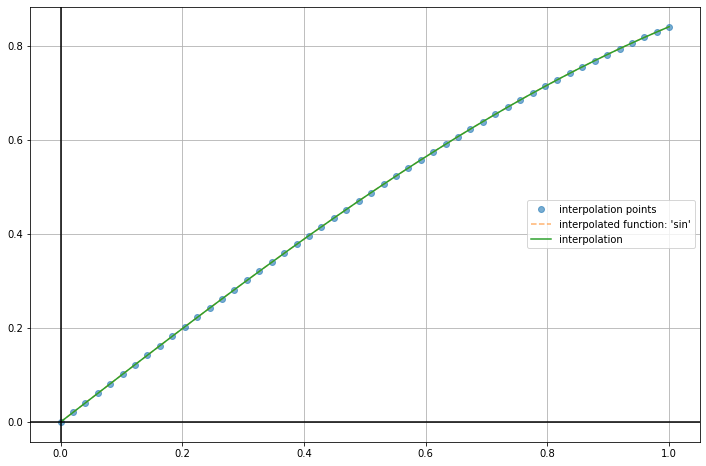

---------------------------------------
formula: 

for x in [0.000, 0.020]       -0.167x^3+0.000x^2+1.000x+0.000
for x in [0.020, 0.041]       -0.167x^3-0.000x^2+1.000x-0.000
for x in [0.041, 0.061]       -0.166x^3-0.000x^2+1.000x-0.000
for x in [0.061, 0.082]       -0.166x^3-0.000x^2+1.000x-0.000
for x in [0.082, 0.102]       -0.166x^3-0.000x^2+1.000x-0.000
for x in [0.102, 0.122]       -0.166x^3-0.000x^2+1.000x-0.000
for x in [0.122, 0.143]       -0.165x^3-0.000x^2+1.000x-0.000
for x in [0.143, 0.163]       -0.165x^3-0.001x^2+1.000x-0.000
for x in [0.163, 0.184]       -0.164x^3-0.001x^2+1.000x-0.000
for x in [0.184, 0.204]       -0.164x^3-0.001x^2+1.000x-0.000
for x in [0.204, 0.224]       -0.163x^3-0.002x^2+1.000x-0.000
for x in [0.224, 0.245]       -0.162x^3-0.002x^2+1.000x-0.000
for x in [0.245, 0.265]       -0.161x^3-0.003x^2+1.001x-0.000
for x in [0.265, 0.286]       -0.160x^3-0.003x^2+1.001x-0.000
for x in [0.286, 0.306]       -0.159x^3-0.004x^2+1.001x-0.000
for x in [0.306, 0.

In [ ]:
testing(X_test=X_test, int_type='cubic', func_test=func_test)

#### Lagrange interpoplation

---------------------------------------
function:  x^2


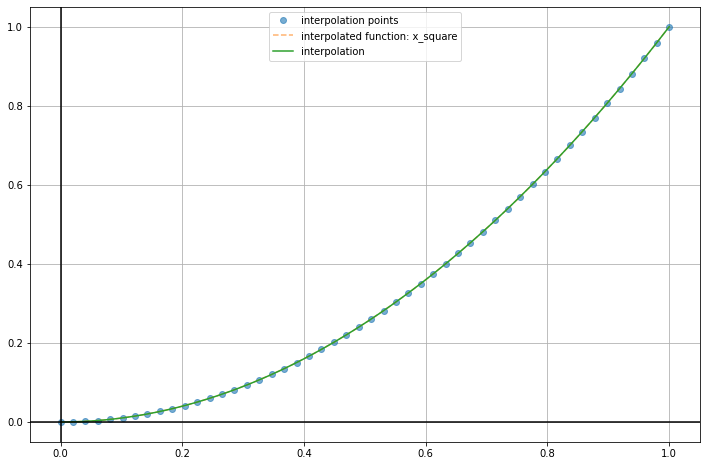

---------------------------------------
formula: 

0.000/-0.000*(x-0.020)(x-0.041)(x-0.061)(x-0.082)(x-0.102)(x-0.122)(x-0.143)(x-0.163)(x-0.184)(x-0.204)(x-0.224)(x-0.245)(x-0.265)(x-0.286)(x-0.306)(x-0.327)(x-0.347)(x-0.367)(x-0.388)(x-0.408)(x-0.429)(x-0.449)(x-0.469)(x-0.490)(x-0.510)(x-0.531)(x-0.551)(x-0.571)(x-0.592)(x-0.612)(x-0.633)(x-0.653)(x-0.673)(x-0.694)(x-0.714)(x-0.735)(x-0.755)(x-0.776)(x-0.796)(x-0.816)(x-0.837)(x-0.857)(x-0.878)(x-0.898)(x-0.918)(x-0.939)(x-0.959)(x-0.980)(x-1.000)+ 
0.000/0.000*(x-0.000)(x-0.041)(x-0.061)(x-0.082)(x-0.102)(x-0.122)(x-0.143)(x-0.163)(x-0.184)(x-0.204)(x-0.224)(x-0.245)(x-0.265)(x-0.286)(x-0.306)(x-0.327)(x-0.347)(x-0.367)(x-0.388)(x-0.408)(x-0.429)(x-0.449)(x-0.469)(x-0.490)(x-0.510)(x-0.531)(x-0.551)(x-0.571)(x-0.592)(x-0.612)(x-0.633)(x-0.653)(x-0.673)(x-0.694)(x-0.714)(x-0.735)(x-0.755)(x-0.776)(x-0.796)(x-0.816)(x-0.837)(x-0.857)(x-0.878)(x-0.898)(x-0.918)(x-0.939)(x-0.959)(x-0.980)(x-1.000)+ 
0.002/-0.000*(x-0.000)(x-0.020)(x-0.

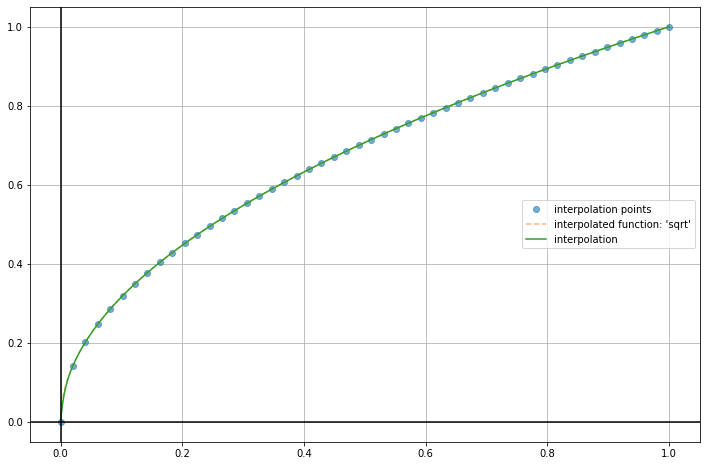

---------------------------------------
formula: 

0.000/-0.000*(x-0.020)(x-0.041)(x-0.061)(x-0.082)(x-0.102)(x-0.122)(x-0.143)(x-0.163)(x-0.184)(x-0.204)(x-0.224)(x-0.245)(x-0.265)(x-0.286)(x-0.306)(x-0.327)(x-0.347)(x-0.367)(x-0.388)(x-0.408)(x-0.429)(x-0.449)(x-0.469)(x-0.490)(x-0.510)(x-0.531)(x-0.551)(x-0.571)(x-0.592)(x-0.612)(x-0.633)(x-0.653)(x-0.673)(x-0.694)(x-0.714)(x-0.735)(x-0.755)(x-0.776)(x-0.796)(x-0.816)(x-0.837)(x-0.857)(x-0.878)(x-0.898)(x-0.918)(x-0.939)(x-0.959)(x-0.980)(x-1.000)+ 
0.143/0.000*(x-0.000)(x-0.041)(x-0.061)(x-0.082)(x-0.102)(x-0.122)(x-0.143)(x-0.163)(x-0.184)(x-0.204)(x-0.224)(x-0.245)(x-0.265)(x-0.286)(x-0.306)(x-0.327)(x-0.347)(x-0.367)(x-0.388)(x-0.408)(x-0.429)(x-0.449)(x-0.469)(x-0.490)(x-0.510)(x-0.531)(x-0.551)(x-0.571)(x-0.592)(x-0.612)(x-0.633)(x-0.653)(x-0.673)(x-0.694)(x-0.714)(x-0.735)(x-0.755)(x-0.776)(x-0.796)(x-0.816)(x-0.837)(x-0.857)(x-0.878)(x-0.898)(x-0.918)(x-0.939)(x-0.959)(x-0.980)(x-1.000)+ 
0.202/-0.000*(x-0.000)(x-0.020)(x-0.

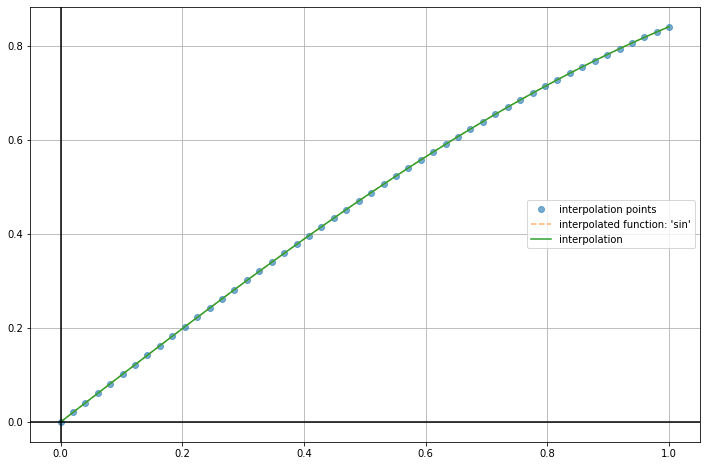

---------------------------------------
formula: 

0.000/-0.000*(x-0.020)(x-0.041)(x-0.061)(x-0.082)(x-0.102)(x-0.122)(x-0.143)(x-0.163)(x-0.184)(x-0.204)(x-0.224)(x-0.245)(x-0.265)(x-0.286)(x-0.306)(x-0.327)(x-0.347)(x-0.367)(x-0.388)(x-0.408)(x-0.429)(x-0.449)(x-0.469)(x-0.490)(x-0.510)(x-0.531)(x-0.551)(x-0.571)(x-0.592)(x-0.612)(x-0.633)(x-0.653)(x-0.673)(x-0.694)(x-0.714)(x-0.735)(x-0.755)(x-0.776)(x-0.796)(x-0.816)(x-0.837)(x-0.857)(x-0.878)(x-0.898)(x-0.918)(x-0.939)(x-0.959)(x-0.980)(x-1.000)+ 
0.020/0.000*(x-0.000)(x-0.041)(x-0.061)(x-0.082)(x-0.102)(x-0.122)(x-0.143)(x-0.163)(x-0.184)(x-0.204)(x-0.224)(x-0.245)(x-0.265)(x-0.286)(x-0.306)(x-0.327)(x-0.347)(x-0.367)(x-0.388)(x-0.408)(x-0.429)(x-0.449)(x-0.469)(x-0.490)(x-0.510)(x-0.531)(x-0.551)(x-0.571)(x-0.592)(x-0.612)(x-0.633)(x-0.653)(x-0.673)(x-0.694)(x-0.714)(x-0.735)(x-0.755)(x-0.776)(x-0.796)(x-0.816)(x-0.837)(x-0.857)(x-0.878)(x-0.898)(x-0.918)(x-0.939)(x-0.959)(x-0.980)(x-1.000)+ 
0.041/-0.000*(x-0.000)(x-0.020)(x-0.

In [ ]:
testing(X_test=X_test, int_type='lagrange', func_test=func_test)

#### Trigonometric interpolation

---------------------------------------
function:  x^2


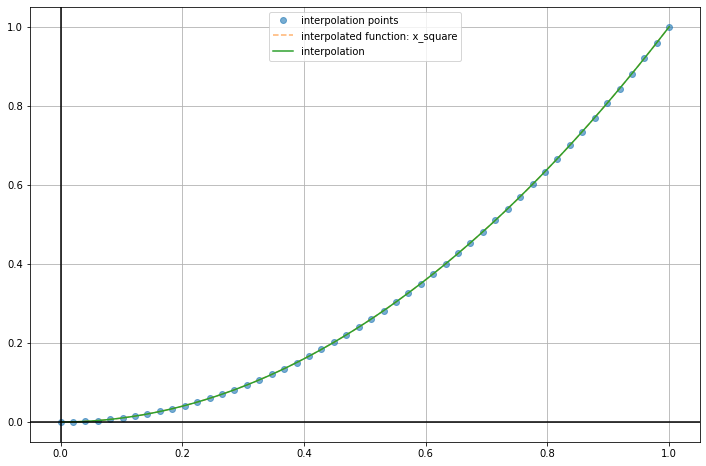

---------------------------------------
formula: 

-8.672 + 49.278*e^(1ix) - 116.299*e^(2ix) + 78.558*e^(3ix) + 243.402*e^(4ix) - 701.571*e^(5ix) + 833.435*e^(6ix) - 508.726*e^(7ix) + 48.603*e^(8ix) + 260.511*e^(9ix) - 308.897*e^(10ix) + 178.773*e^(11ix) - 61.508*e^(12ix) + 81.396*e^(13ix) - 116.817*e^(14ix) - 175.606*e^(15ix) + 341.302*e^(16ix) + 89.794*e^(17ix) - 117.059*e^(18ix) - 225.922*e^(19ix) + 4.098*e^(20ix) + 17.291*e^(21ix) + 158.835*e^(22ix) + 120.135*e^(23ix) - 82.688*e^(24ix) - 155.375*e^(25ix) + 92.627*e^(26ix) - 116.800*e^(27ix) + 79.779*e^(28ix) + 36.672*e^(29ix) + 45.878*e^(30ix) - 68.980*e^(31ix) - 36.846*e^(32ix) + 41.576*e^(33ix) + 10.420*e^(34ix) + 15.876*e^(35ix) + 25.246*e^(36ix) - 186.815*e^(37ix) + 175.558*e^(38ix) + 11.896*e^(39ix) - 118.132*e^(40ix) + 163.972*e^(41ix) - 198.933*e^(42ix) + 148.713*e^(43ix) - 59.005*e^(44ix) + 15.504*e^(45ix) - 7.547*e^(46ix) + 3.983*e^(47ix) - 1.004*e^(48ix) + 0.089*e^(49ix)
---------------------------------------
mean L2 err

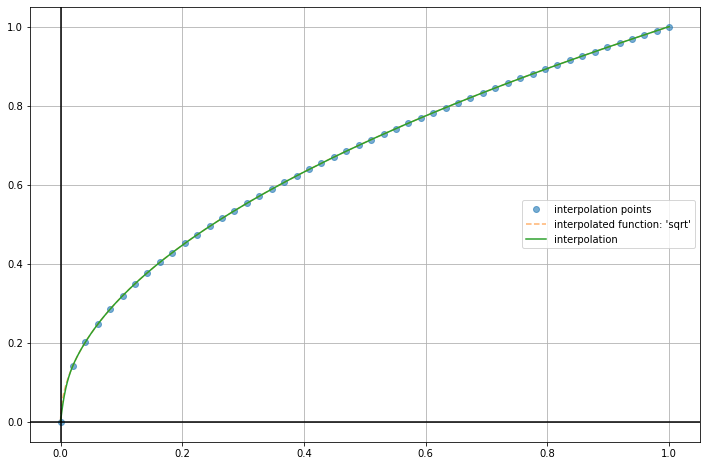

---------------------------------------
formula: 

-5216349.976 + 120545901.970*e^(1ix) - 887760410.492*e^(2ix) + 2947658825.543*e^(3ix) - 4238301366.069*e^(4ix) - 80281684.534*e^(5ix) + 7477616517.121*e^(6ix) - 7109289832.078*e^(7ix) + 1457687783.717*e^(8ix) - 2095695791.312*e^(9ix) + 2088511611.557*e^(10ix) + 2494017974.926*e^(11ix) + 412682094.295*e^(12ix) - 2607639560.706*e^(13ix) - 3668933532.360*e^(14ix) + 3137217558.985*e^(15ix) + 1033097221.866*e^(16ix) + 1561710731.083*e^(17ix) - 3104193048.296*e^(18ix) + 2396879508.402*e^(19ix) - 1916318931.556*e^(20ix) - 1795244524.996*e^(21ix) + 5431539143.872*e^(22ix) - 4062301646.075*e^(23ix) + 1161899848.388*e^(24ix) + 386114366.244*e^(25ix) - 1301571244.842*e^(26ix) - 768684464.167*e^(27ix) + 1267164776.626*e^(28ix) + 1986292811.277*e^(29ix) - 343744687.121*e^(30ix) - 305697407.386*e^(31ix) - 3205670287.087*e^(32ix) + 221657336.462*e^(33ix) + 1903945440.607*e^(34ix) + 1694003854.701*e^(35ix) - 752793965.059*e^(36ix) - 1158144636.946*e^(

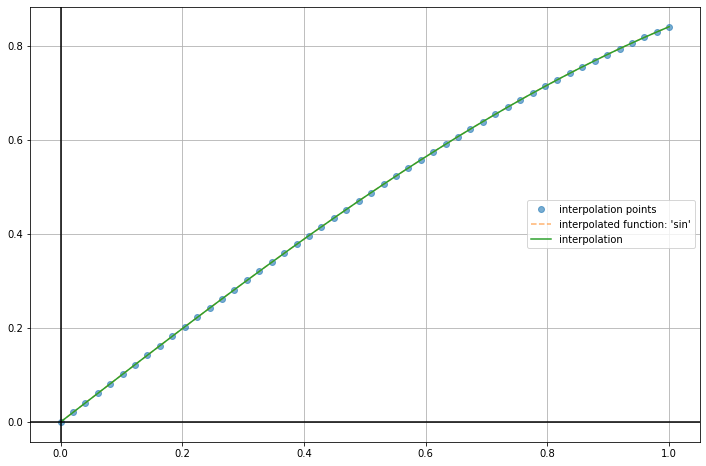

---------------------------------------
formula: 

3.247 - 39.298*e^(1ix) + 198.260*e^(2ix) - 539.654*e^(3ix) + 849.189*e^(4ix) - 748.047*e^(5ix) + 266.038*e^(6ix) + 174.341*e^(7ix) - 365.643*e^(8ix) + 299.865*e^(9ix) + 18.911*e^(10ix) - 379.995*e^(11ix) + 446.448*e^(12ix) - 169.326*e^(13ix) - 27.514*e^(14ix) + 92.796*e^(15ix) - 296.131*e^(16ix) + 69.065*e^(17ix) + 359.057*e^(18ix) - 61.021*e^(19ix) - 25.067*e^(20ix) - 297.700*e^(21ix) - 24.680*e^(22ix) + 249.226*e^(23ix) - 62.870*e^(24ix) + 62.999*e^(25ix) + 22.399*e^(26ix) + 18.789*e^(27ix) - 230.598*e^(28ix) + 87.690*e^(29ix) + 111.704*e^(30ix) - 113.128*e^(31ix) + 145.790*e^(32ix) - 174.899*e^(33ix) + 104.448*e^(34ix) - 83.851*e^(35ix) + 152.533*e^(36ix) - 84.132*e^(37ix) - 42.973*e^(38ix) - 25.206*e^(39ix) + 121.444*e^(40ix) - 90.983*e^(41ix) + 67.553*e^(42ix) - 69.037*e^(43ix) + 31.124*e^(44ix) + 5.836*e^(45ix) - 9.433*e^(46ix) + 2.552*e^(47ix) - 0.085*e^(48ix) - 0.033*e^(49ix)
---------------------------------------
mean L2 erro

In [ ]:
testing(X_test=X_test, int_type='trigonometric', func_test=func_test)

#### Error analysis

In [ ]:
error_matrix

{'error L1 in cubic interpolation for function sinus': 2.1042743870501672e-08,
 'error L1 in cubic interpolation for function square root': 2.2179650208215867e-05,
 'error L1 in cubic interpolation for function x^2': 9.954471991178218e-08,
 'error L1 in lagrange interpolation for function sinus': 4.6542472356392745e-09,
 'error L1 in lagrange interpolation for function square root': 3.305207227208448e-07,
 'error L1 in lagrange interpolation for function x^2': 3.010243759051579e-09,
 'error L1 in linear interpolation for function sinus': 1.5892478710374163e-05,
 'error L1 in linear interpolation for function square root': 8.21913917606593e-05,
 'error L1 in linear interpolation for function x^2': 6.802721088435423e-05,
 'error L1 in quadratic interpolation for function sinus': 0.0033334490625666242,
 'error L1 in quadratic interpolation for function square root': 0.035476030535066164,
 'error L1 in quadratic interpolation for function x^2': 1.7780915628762273e-17,
 'error L1 in trigono

maximum error

In [ ]:
max_err = max(error_matrix, key = error_matrix.get) 
print(max_err, max(error_matrix.values()))

error L1 in quadratic interpolation for function square root 0.035476030535066164


minimum error

In [ ]:
min_err = min(error_matrix, key = error_matrix.get)
print(min_err, min(error_matrix.values()))

error L2 in quadratic interpolation for function x^2 5.4901374714726796e-18


## Testing bestfit

In [ ]:
def testing_best(int_type, func_test, a=0, b=5, nodes_type='equidistant', start=3, max_iters=100, tolerance=1e-10, last_errors_plot=50): 
  inter = interpolation(int_type = int_type)
  for num in func_test:
    print('---------------------------------------')
    print('function: ', num)
    print('Norm: L1')
    print('---------------------------------------')   
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    inter.bestfit(a,b, func=func_test[num], norm='L1', nodes_type=nodes_type, start=start, max_iters=max_iters, tolerance=tolerance, last_errors_plot=last_errors_plot)
    plt.subplot(122)
    inter.graph()
    plt.show()

    print('---------------------------------------')
    print('function: ', num)
    print('Norm: L2')
    print('---------------------------------------')
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    inter.bestfit(a,b, func=func_test[num], norm='L2', nodes_type=nodes_type, start=start, max_iters=max_iters, tolerance=tolerance, last_errors_plot=last_errors_plot)
    plt.subplot(122)
    inter.graph()
    plt.show()


### Linear Spline

---------------------------------------
function:  x^2
Norm: L1
---------------------------------------
best fit for 1003 nodes, with error of 4.101354163455048e-06


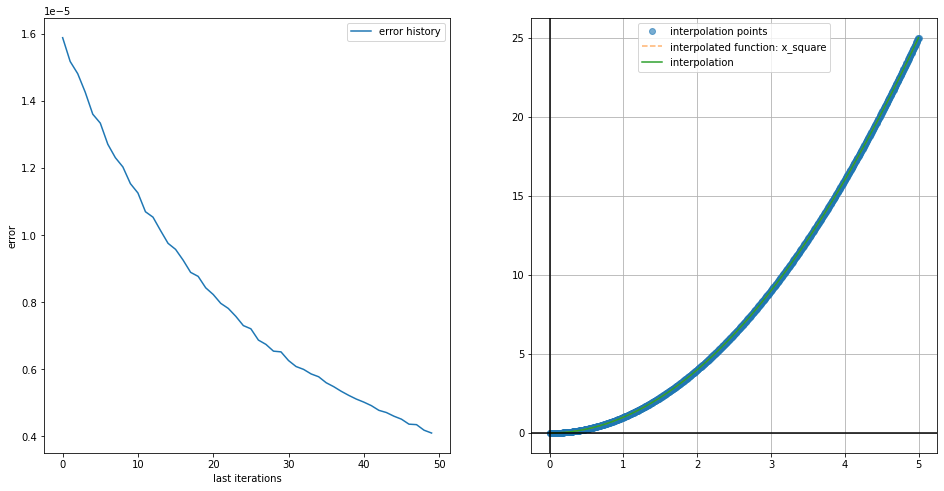

---------------------------------------
function:  x^2
Norm: L2
---------------------------------------
best fit for 1003 nodes, with error of 1.438601221067141e-07


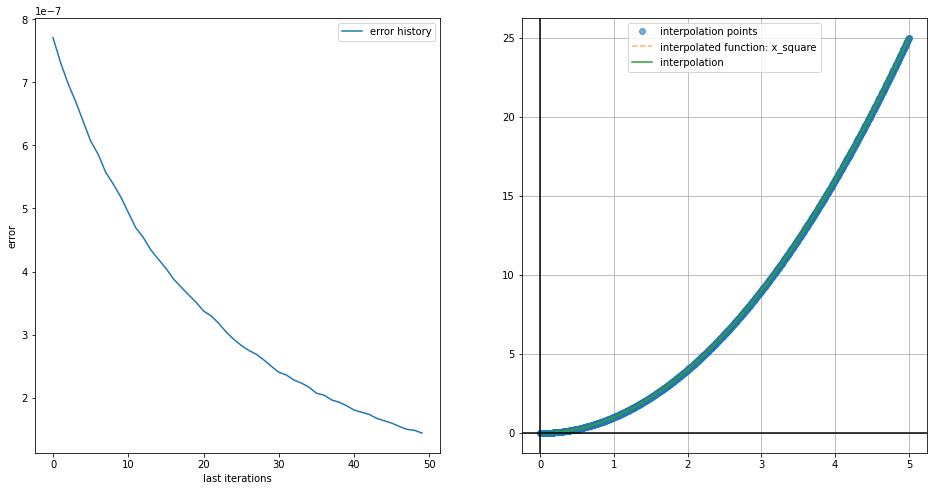

---------------------------------------
function:  square root
Norm: L1
---------------------------------------
best fit for 983 nodes, with error of 1.085398245315838e-05


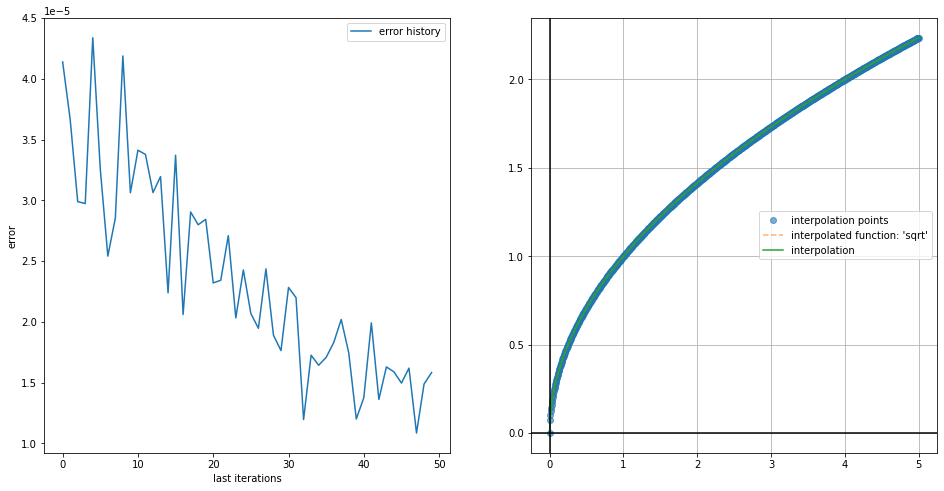

---------------------------------------
function:  square root
Norm: L2
---------------------------------------
best fit for 973 nodes, with error of 4.7897974593167e-06


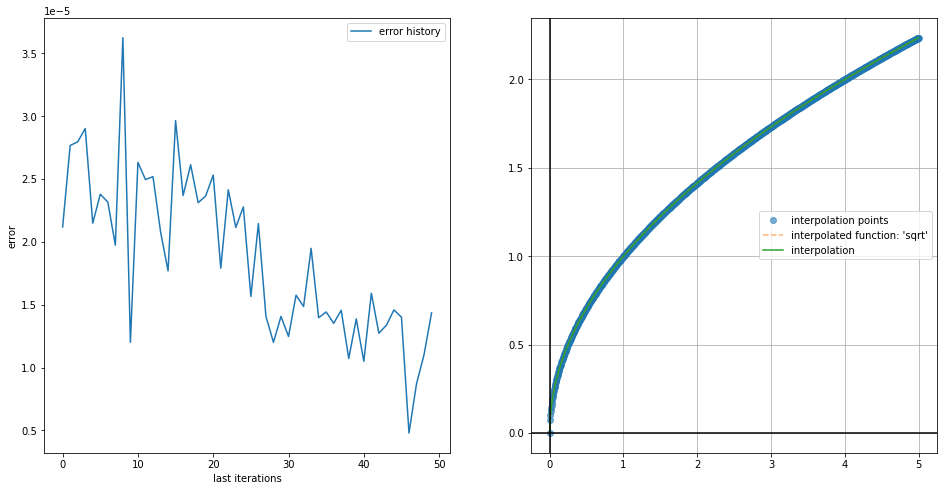

---------------------------------------
function:  sinus
Norm: L1
---------------------------------------
best fit for 1003 nodes, with error of 1.3439944357158007e-06


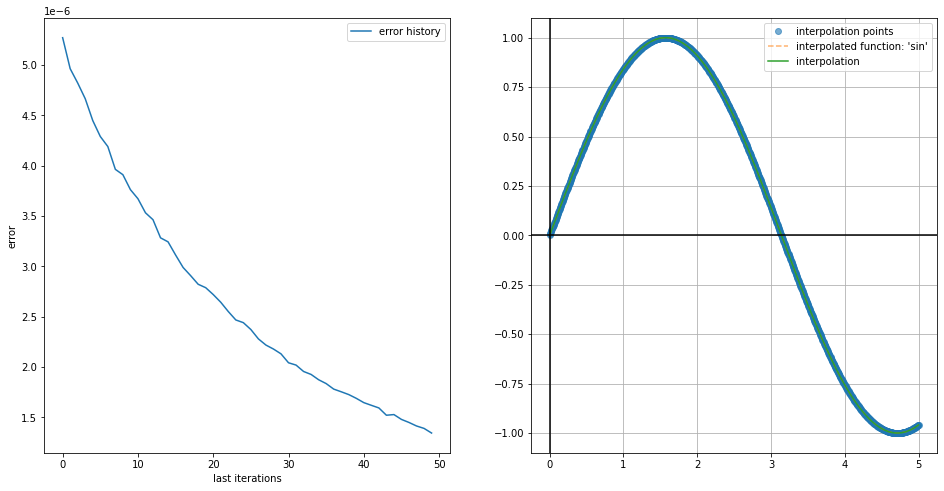

---------------------------------------
function:  sinus
Norm: L2
---------------------------------------
best fit for 1003 nodes, with error of 5.296961599599013e-08


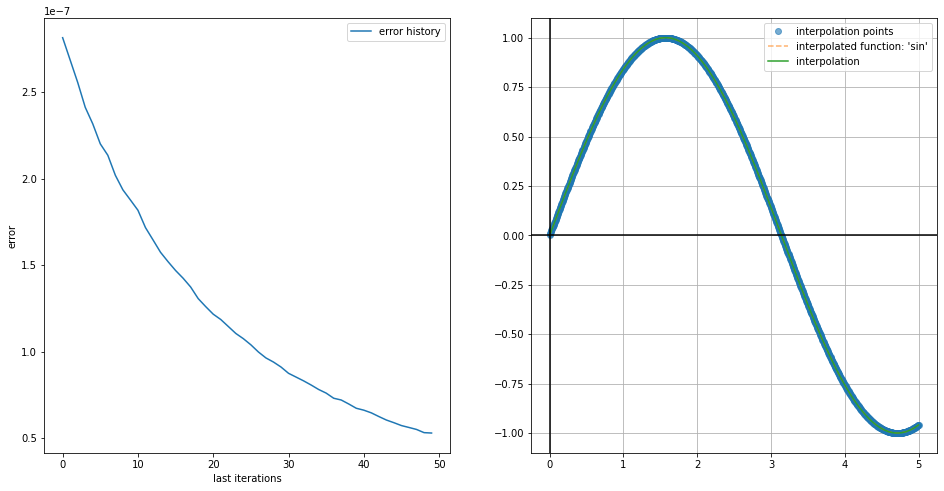

In [ ]:
testing_best('linear', func_test=func_test )

### Quadratic Spline

---------------------------------------
function:  x^2
Norm: L1
---------------------------------------
best fit for 3 nodes, with error of 0.0


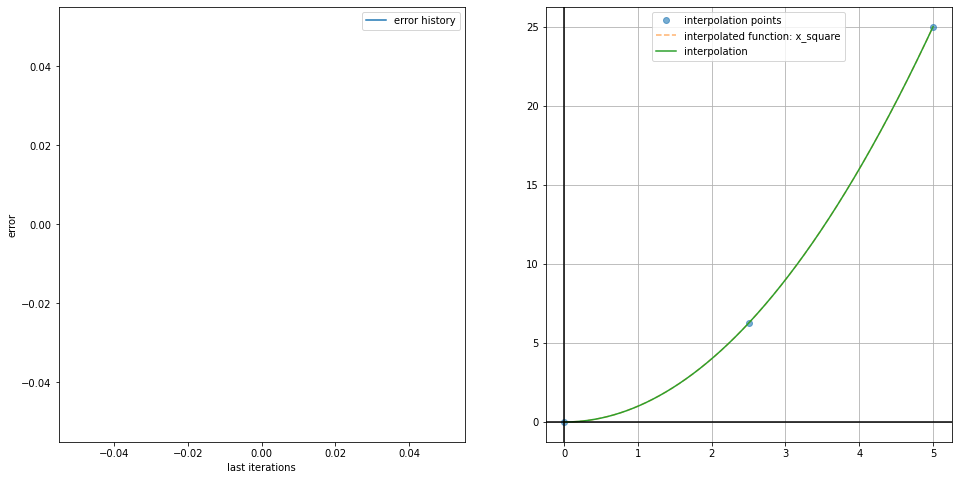

---------------------------------------
function:  x^2
Norm: L2
---------------------------------------
best fit for 3 nodes, with error of 0.0


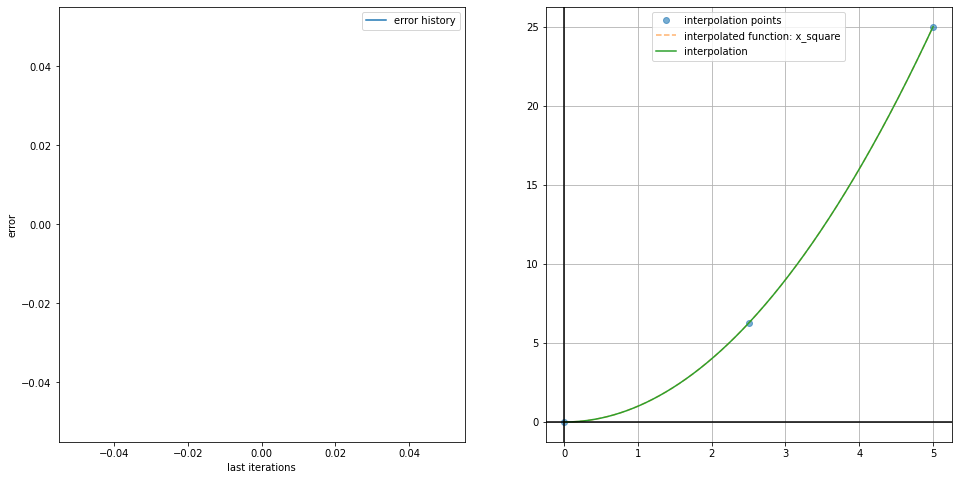

---------------------------------------
function:  square root
Norm: L1
---------------------------------------
best fit for 1003 nodes, with error of 0.017866726493842168


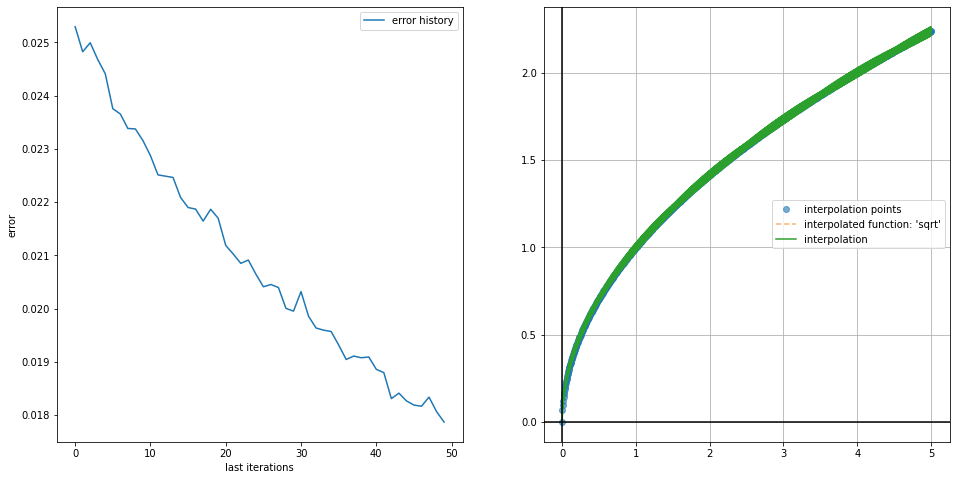

---------------------------------------
function:  square root
Norm: L2
---------------------------------------
best fit for 1003 nodes, with error of 0.0006215818617053322


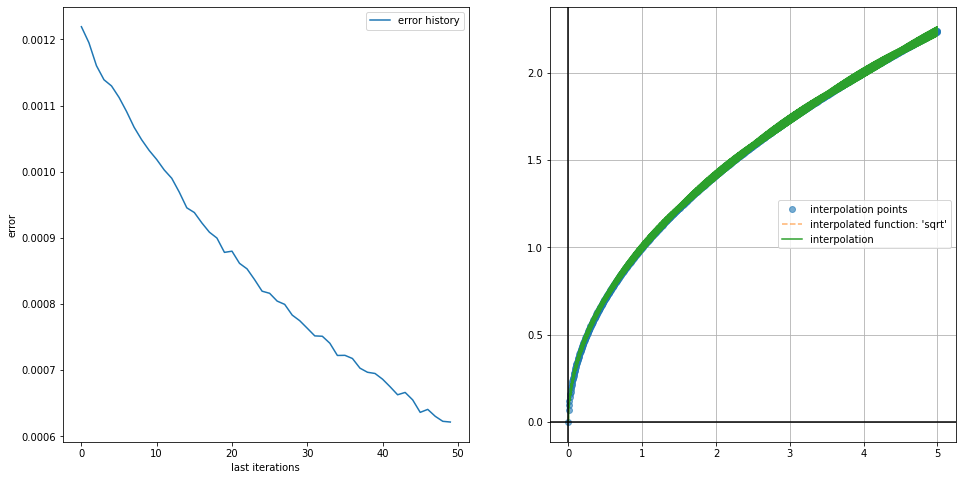

---------------------------------------
function:  sinus
Norm: L1
---------------------------------------
best fit for 1003 nodes, with error of 0.0008310734702259374


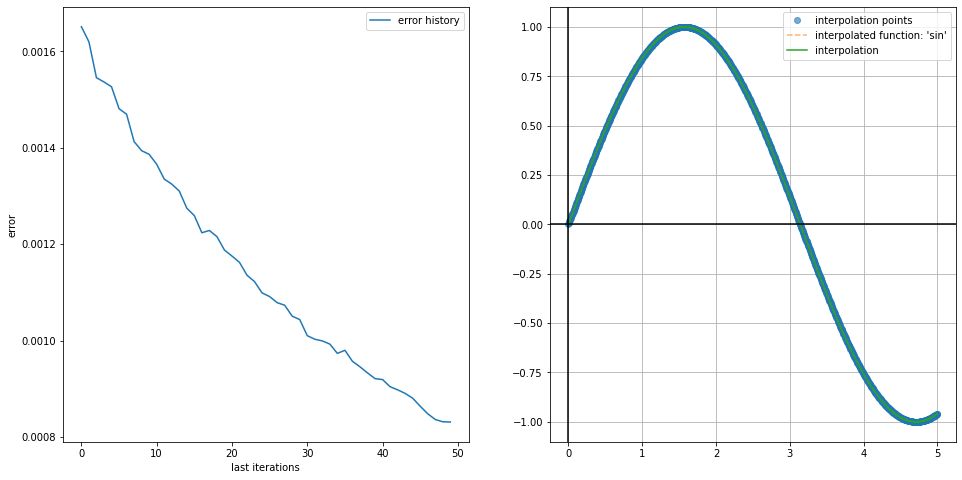

---------------------------------------
function:  sinus
Norm: L2
---------------------------------------
best fit for 1003 nodes, with error of 2.893195390380121e-05


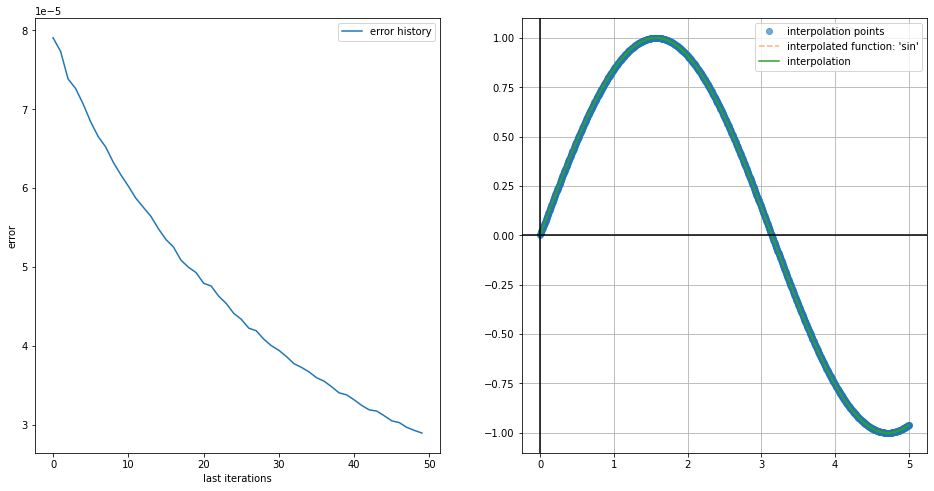

In [ ]:
testing_best('quadratic', func_test=func_test, tolerance=1e-20)

### Cubic Spline

---------------------------------------
function:  x^2
Norm: L1
---------------------------------------
best fit for 103 nodes, with error of 2.4016914759872973e-06


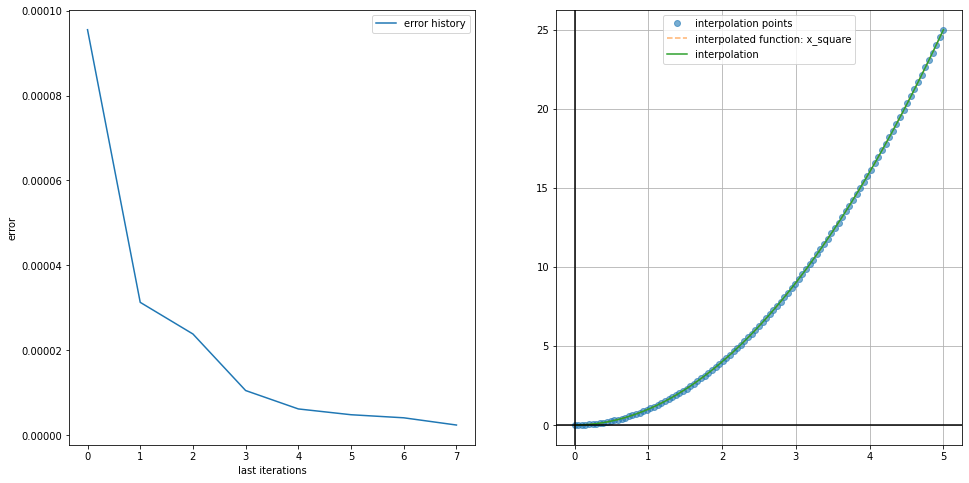

---------------------------------------
function:  x^2
Norm: L2
---------------------------------------
best fit for 103 nodes, with error of 1.5223020072901403e-06


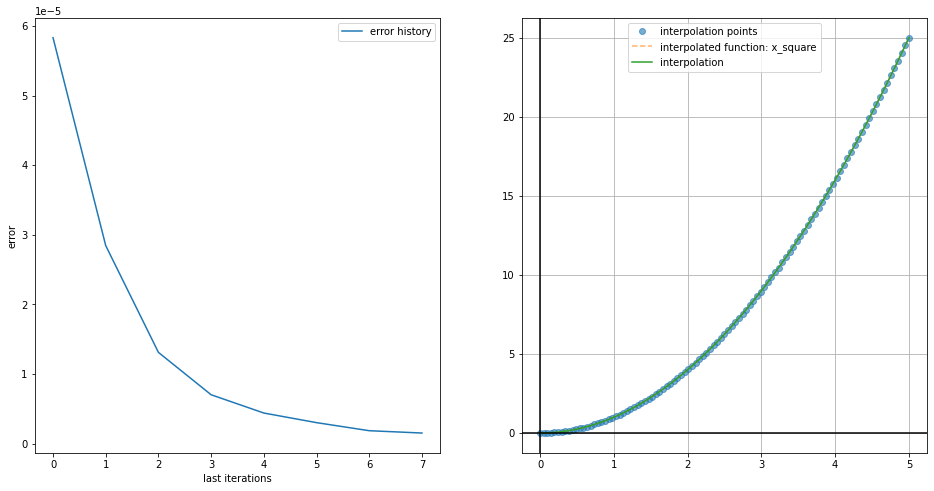

---------------------------------------
function:  square root
Norm: L1
---------------------------------------
best fit for 93 nodes, with error of 0.000352575517871275


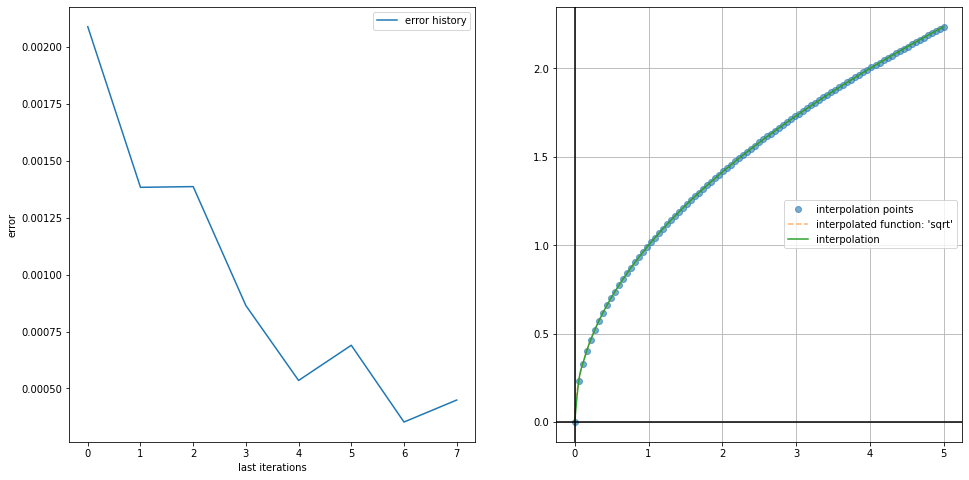

---------------------------------------
function:  square root
Norm: L2
---------------------------------------
best fit for 93 nodes, with error of 0.0003053827743954386


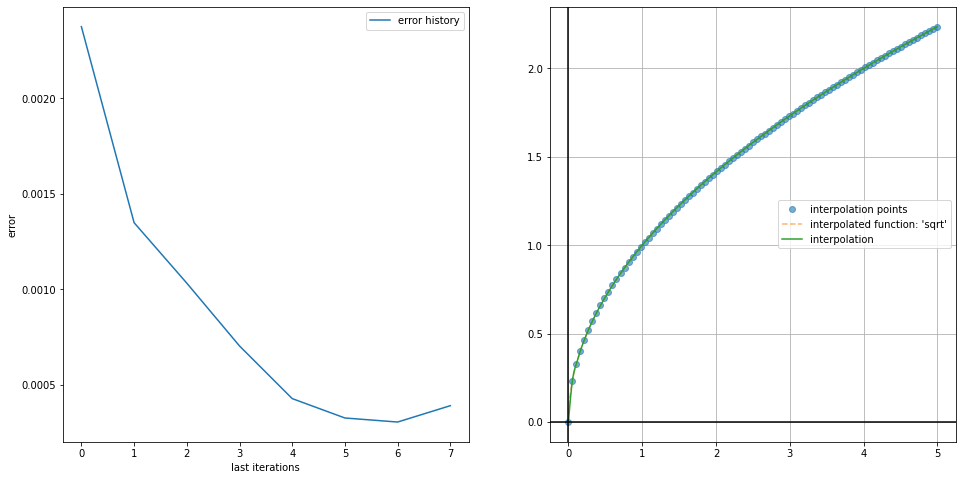

---------------------------------------
function:  sinus
Norm: L1
---------------------------------------
best fit for 103 nodes, with error of 2.189740324080151e-07


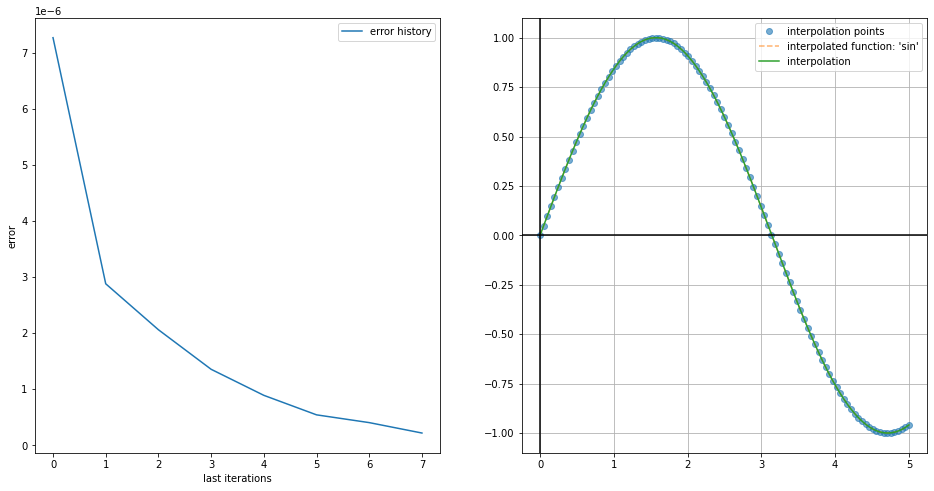

---------------------------------------
function:  sinus
Norm: L2
---------------------------------------
best fit for 103 nodes, with error of 2.535592353511622e-07


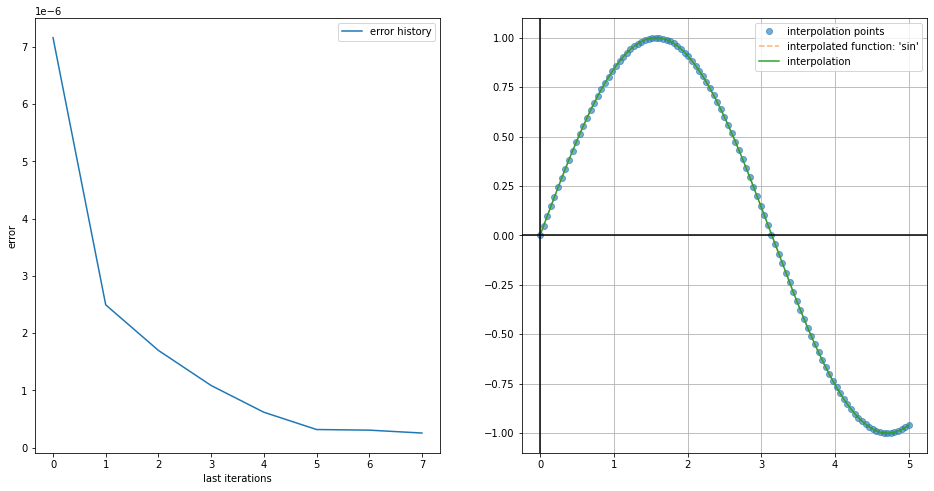

In [ ]:
testing_best('cubic', func_test=func_test, max_iters=10, last_errors_plot=8)

### Lagrange interpolation

---------------------------------------
function:  x^2
Norm: L1
---------------------------------------
best fit for 3 nodes, with error of 2.370499629922307e-16


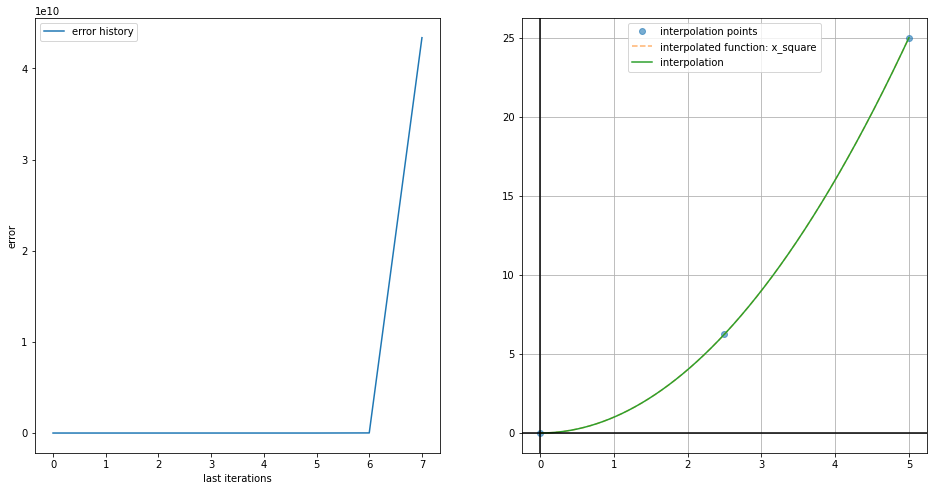

---------------------------------------
function:  x^2
Norm: L2
---------------------------------------
best fit for 3 nodes, with error of 4.666406150377611e-16


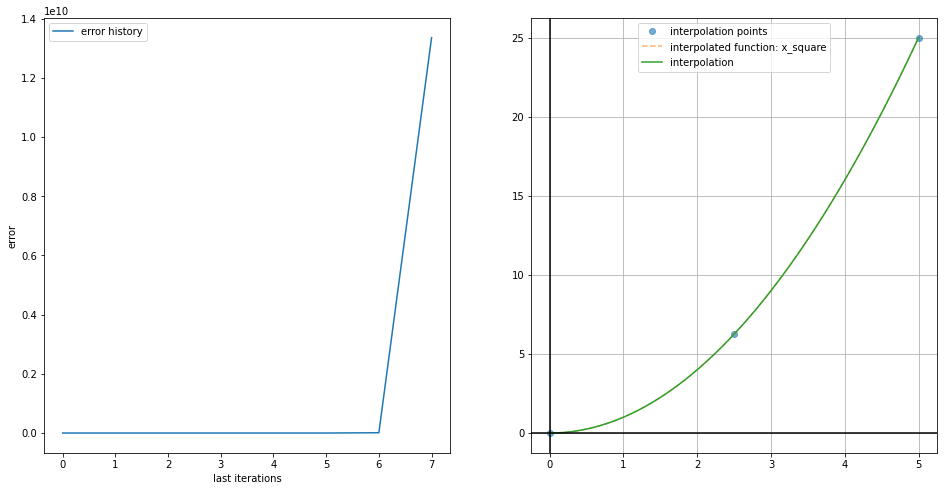

---------------------------------------
function:  square root
Norm: L1
---------------------------------------
best fit for 53 nodes, with error of 0.0002046936801561294


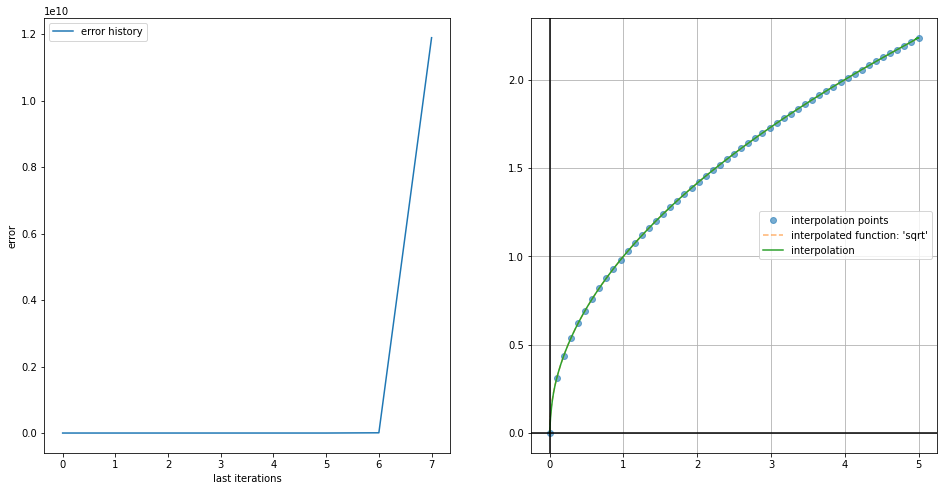

---------------------------------------
function:  square root
Norm: L2
---------------------------------------
best fit for 43 nodes, with error of 0.00013448819177510295


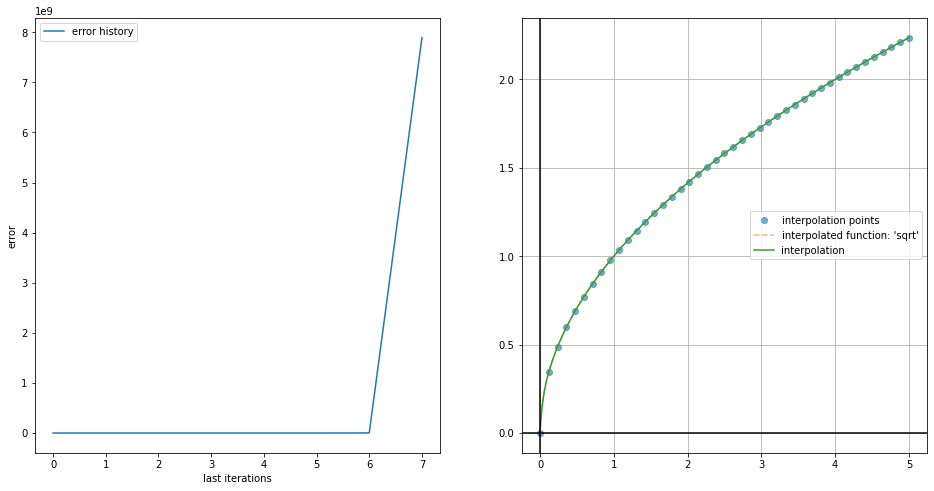

---------------------------------------
function:  sinus
Norm: L1
---------------------------------------
best fit for 23 nodes, with error of 4.218503027056794e-14


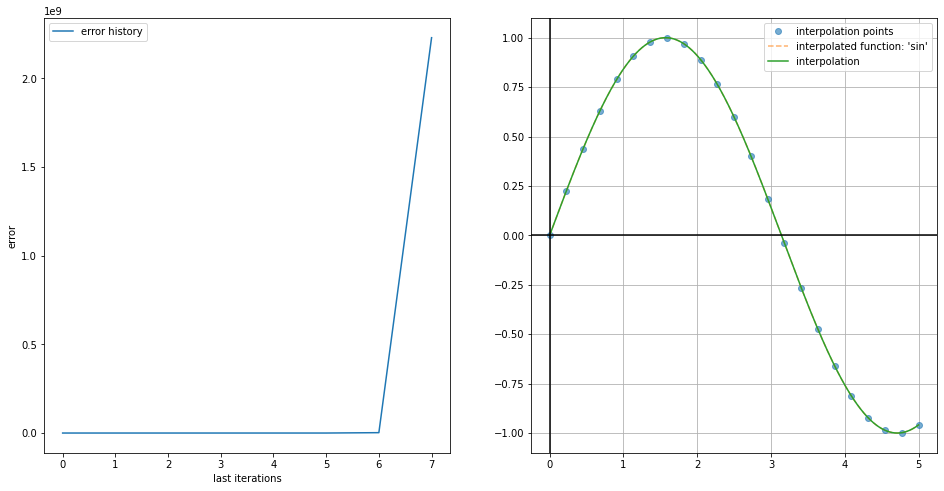

---------------------------------------
function:  sinus
Norm: L2
---------------------------------------
best fit for 23 nodes, with error of 2.908282429815088e-14


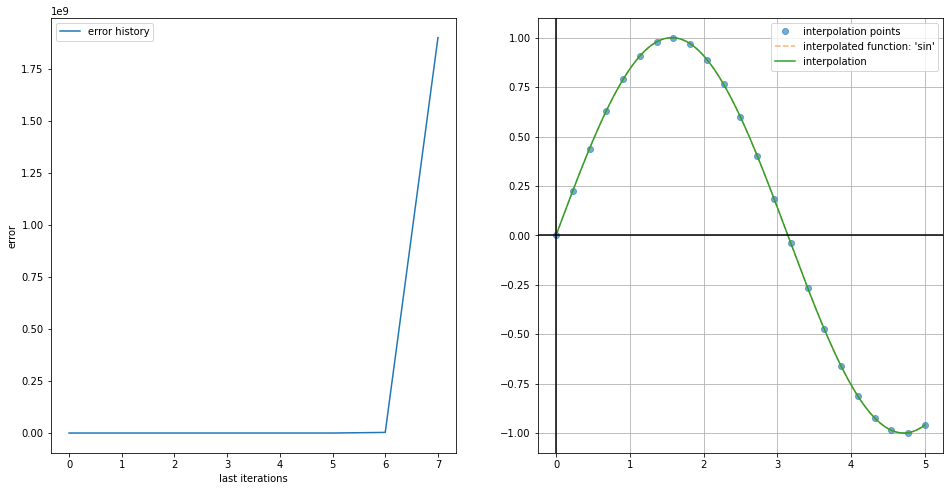

In [ ]:
testing_best('lagrange', func_test=func_test, max_iters=10, tolerance=1e-20, last_errors_plot=8)

### Lagrange interpolation using Chebyshev nodes

---------------------------------------
function:  x^2
Norm: L1
---------------------------------------
best fit for 3 nodes, with error of 1.9984014443252818e-16


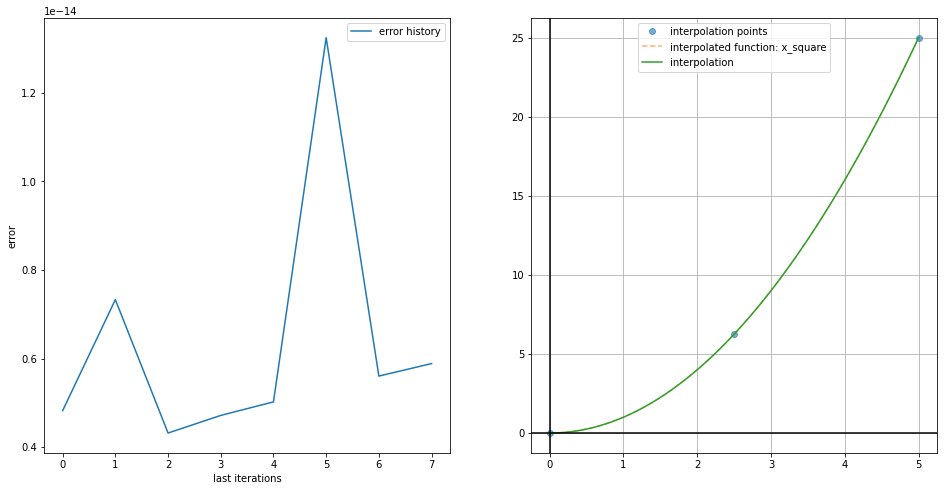

---------------------------------------
function:  x^2
Norm: L2
---------------------------------------
best fit for 3 nodes, with error of 1.454809580095362e-16


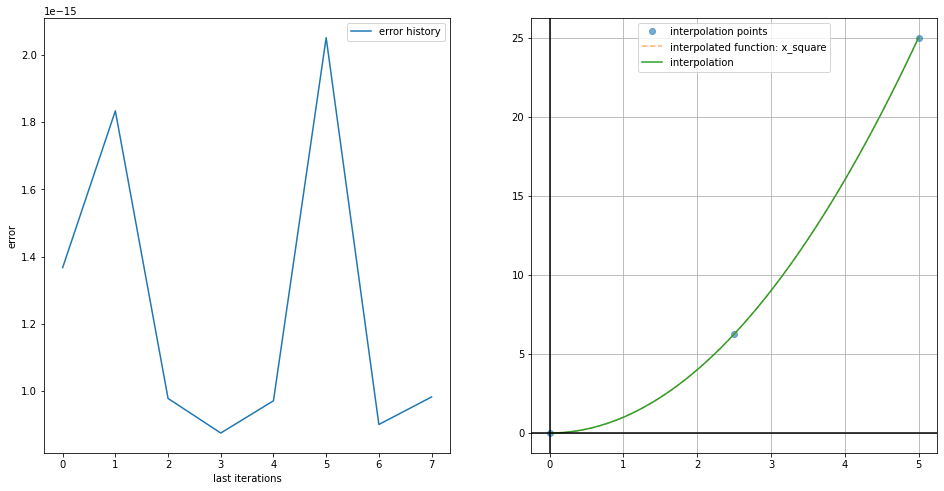

---------------------------------------
function:  square root
Norm: L1
---------------------------------------
best fit for 103 nodes, with error of 0.0036064883974581538


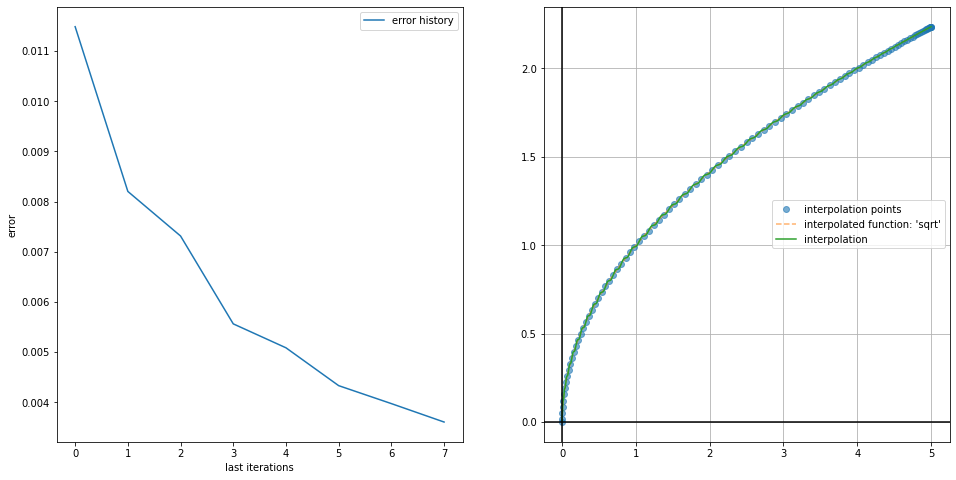

---------------------------------------
function:  square root
Norm: L2
---------------------------------------
best fit for 103 nodes, with error of 0.0004602868010850088


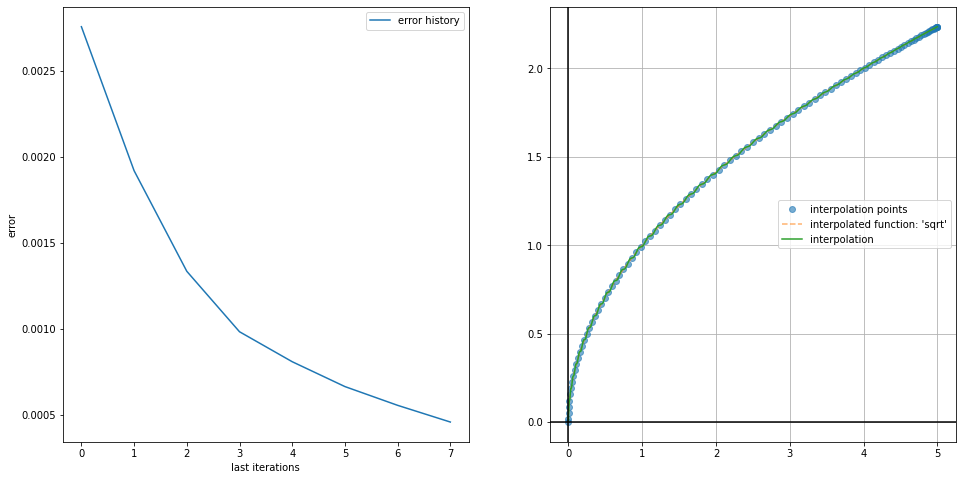

---------------------------------------
function:  sinus
Norm: L1
---------------------------------------
best fit for 23 nodes, with error of 2.6500689043989266e-16


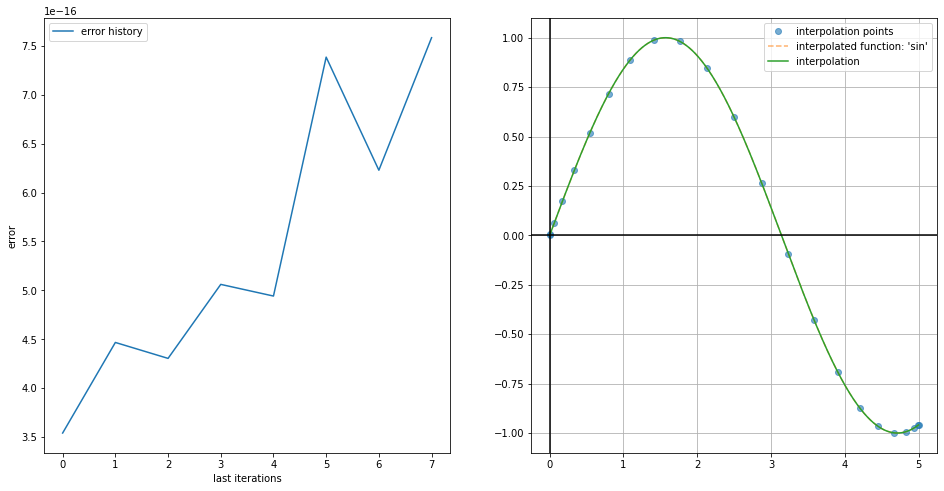

---------------------------------------
function:  sinus
Norm: L2
---------------------------------------
best fit for 23 nodes, with error of 6.933237390032811e-17


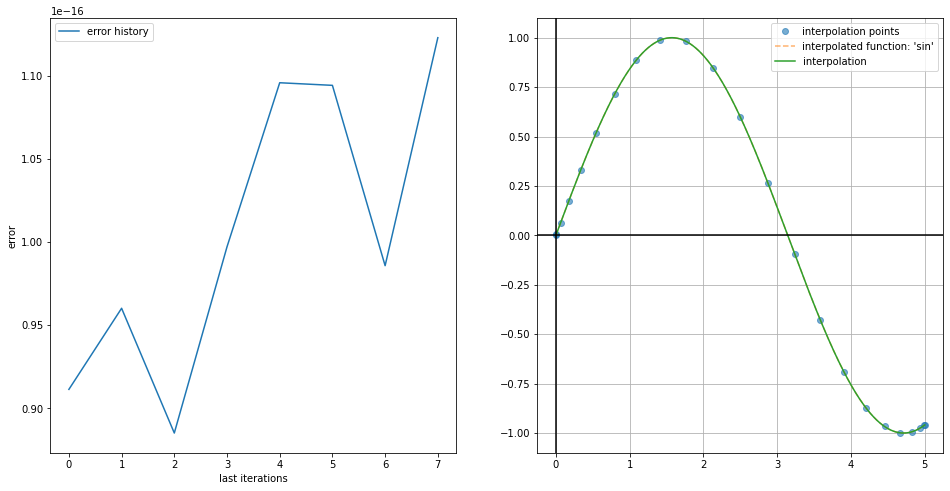

In [ ]:
testing_best('lagrange', func_test=func_test, max_iters=10, start=3, tolerance=1e-20, nodes_type='chebyshev', last_errors_plot=8)

### Trigonometric interpolation

---------------------------------------
function:  x^2
Norm: L1
---------------------------------------
best fit for 43 nodes, with error of 2.2879576657085362e-07


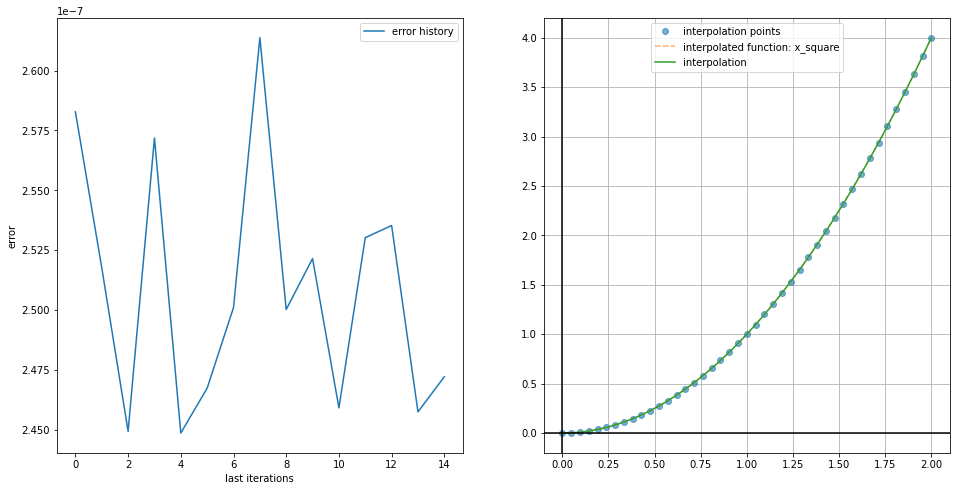

---------------------------------------
function:  x^2
Norm: L2
---------------------------------------
best fit for 203 nodes, with error of 2.004810537026303e-08


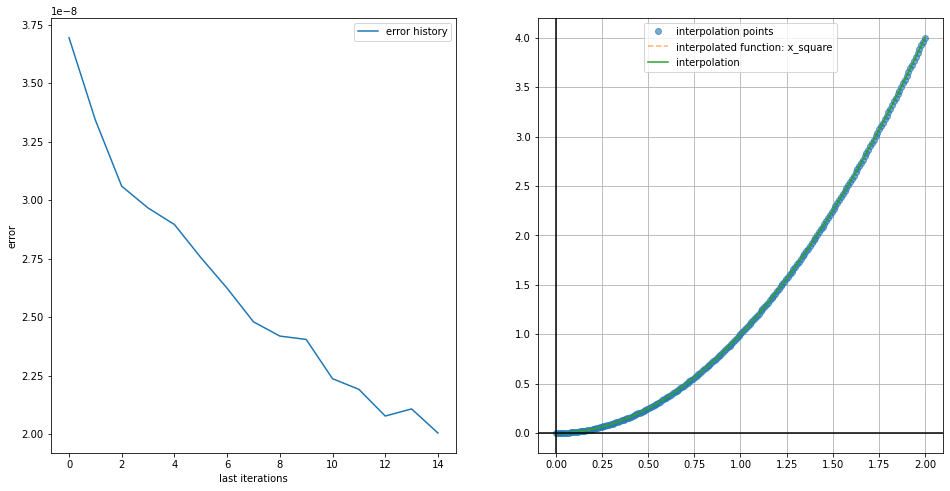

---------------------------------------
function:  square root
Norm: L1
---------------------------------------
best fit for 203 nodes, with error of 1.896497267378232e-05


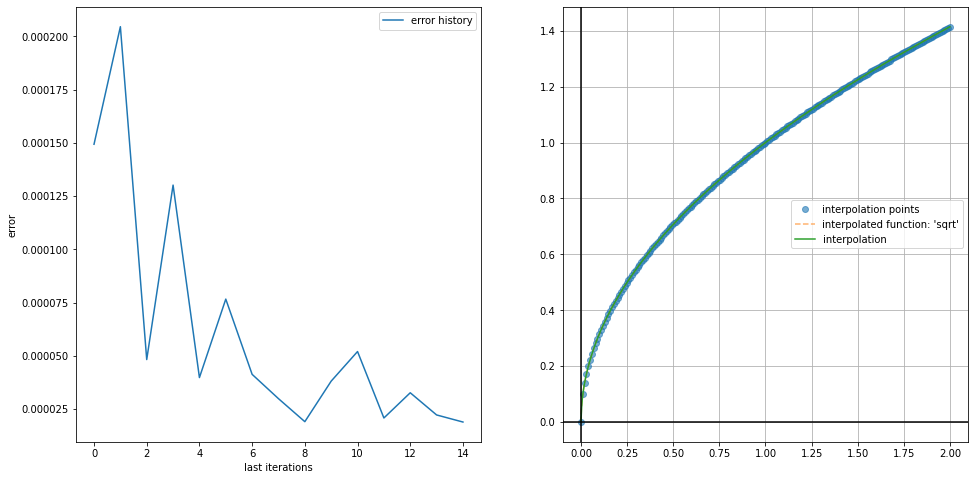

---------------------------------------
function:  square root
Norm: L2
---------------------------------------
best fit for 143 nodes, with error of 1.0760660964173268e-05


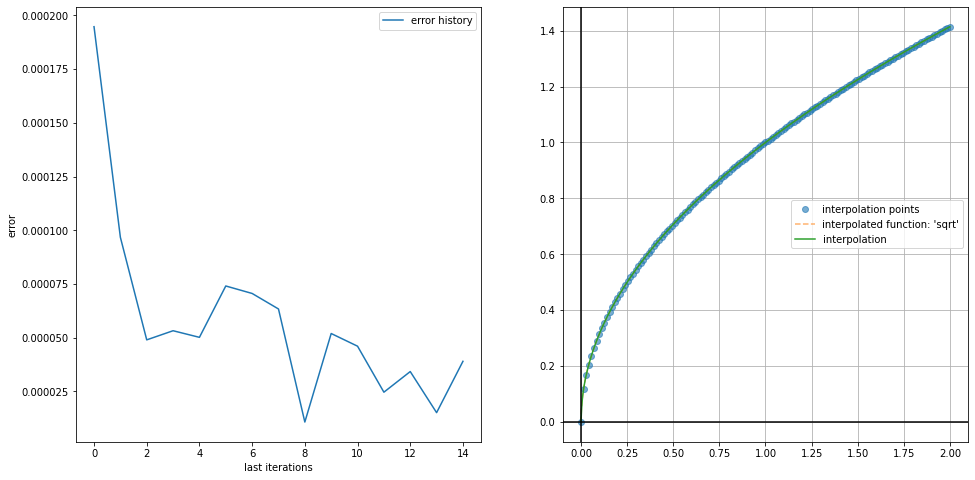

---------------------------------------
function:  sinus
Norm: L1
---------------------------------------
best fit for 73 nodes, with error of 2.4420351355166797e-07


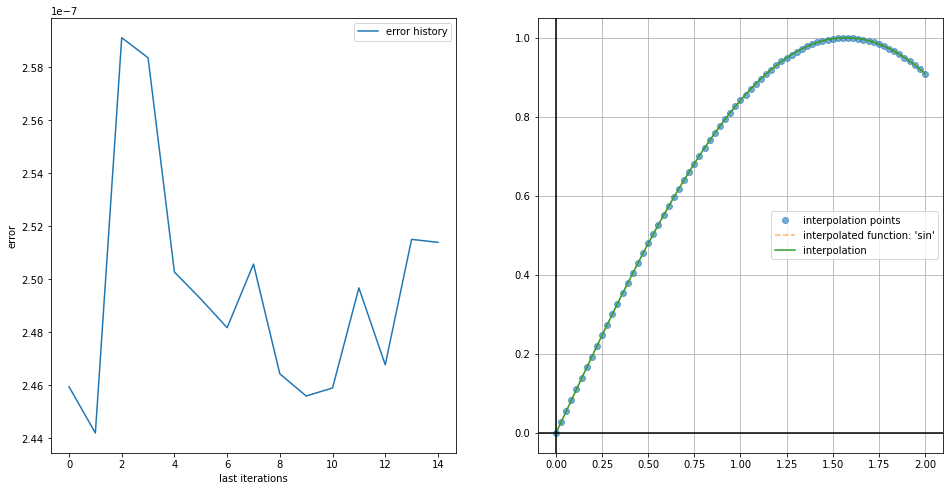

---------------------------------------
function:  sinus
Norm: L2
---------------------------------------
best fit for 203 nodes, with error of 2.022622074166163e-08


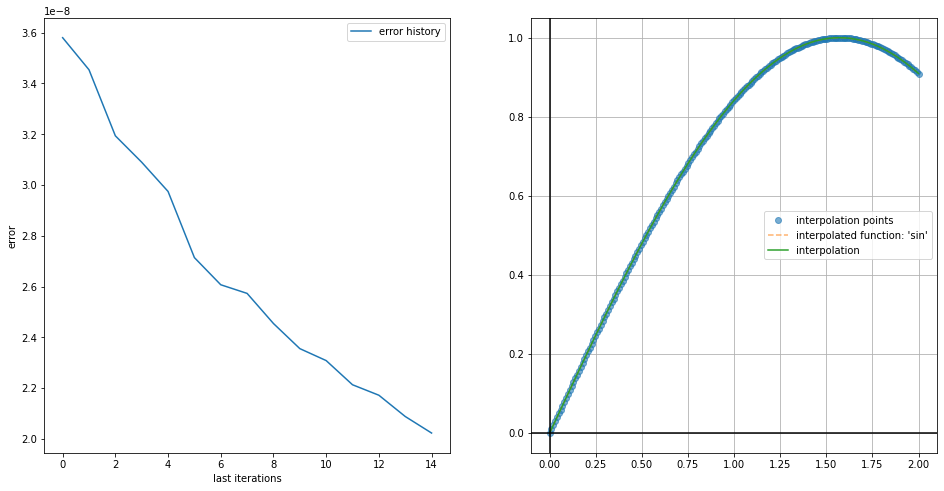

In [ ]:
testing_best('trigonometric', func_test=func_test, max_iters=20, a=0,b=2, last_errors_plot=15)

# Animations


### Linear Spline

In [ ]:
inter = interpolation(int_type='linear')
inter.Animation(a=-15*np.pi, b=15*np.pi, n=75, func=np.sin, norm='L2')

Output hidden; open in https://colab.research.google.com to view.

### Cubic Spline

In [ ]:
inter = interpolation(int_type='cubic')
inter.Animation(a=np.pi/2 + 0.01, b=3/2*np.pi - 0.01 , n=75, func=np.tan, norm='L2')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
inter.Animation(a=-15*np.pi, b=15*np.pi, n=75, func=np.sin, norm='L2')

Output hidden; open in https://colab.research.google.com to view.

### Lagrange

In [ ]:
inter = interpolation(int_type='lagrange')
inter.Animation(a=0, b=15, n=75, func=np.sin, norm='L2')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
inter.Animation(a=0, b=15, n=75, func=np.sin, norm='L2', nodes_type='chebyshev')

Output hidden; open in https://colab.research.google.com to view.

### Trigonometric

In [ ]:
inter = interpolation(int_type='trigonometric')
inter.Animation(a=0, b=15, n=75, func=np.sin, norm='L2')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
inter = interpolation(int_type='trigonometric')
inter.Animation(a=0, b=np.pi, n=75, func=np.sin, norm='L2')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
inter = interpolation(int_type='trigonometric')
inter.Animation(a=0, b=np.pi, n=75, func=np.sin, norm='L2', nodes_type='chebyshev')

Output hidden; open in https://colab.research.google.com to view.